# *Caso de Estudio Nhanes* #

El Estudio Nacional de Examen de Salud y Nutrición (National Health and Nutrition Examination Survey, NHANES) es un programa de encuestas diseñado para evaluar la salud y el estado nutricional de adultos y niños en los Estados Unidos. A través de entrevistas y exámenes físicos, NHANES recopila datos que ayudan a comprender las condiciones prevalentes en la población, como enfermedades crónicas, deficiencias nutricionales, y problemas de salud mental, incluyendo la depresión.

## *Etapa 1: Comprensión del Negocio*

El objetivo de este estudio es (rellenar)

### Inicio

In [1]:
%load_ext kedro.ipython
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import mstats
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [2]:
demografia = catalog.load("demografia")
insulina = catalog.load("insulina")
colesterol = catalog.load("colesterol")
depresion = catalog.load("depresion")
proteinaC = catalog.load("proteinaC")
perfilB = catalog.load("perfilBioquimico")
presion = catalog.load("presionArterial")
medidas = catalog.load("medidasCorporales")
scaler = StandardScaler()
minmax = MinMaxScaler()
pt = PowerTransformer(method='yeo-johnson')
pd.options.display.float_format = '{:.2f}'.format

[09/09/24 11:57:23] INFO     Loading data from demografia (ParquetDataset)...                   ]8;id=253330;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=997193;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

[09/09/24 11:57:24] INFO     Loading data from insulina (ParquetDataset)...                     ]8;id=862113;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=447745;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from colesterol (ParquetDataset)...                   ]8;id=696589;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=160134;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from depresion (ParquetDataset)...                    ]8;id=373838;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=523103;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from proteinaC (ParquetDataset)...                    ]8;id=860485;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=545004;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from perfilBioquimico (ParquetDataset)...             ]8;id=211041;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=951250;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from presionArterial (ParquetDataset)...              ]8;id=887487;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=932499;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from medidasCorporales (ParquetDataset)...            ]8;id=92279;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=580803;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

# Dataframes

In [18]:
consideracion = pd.DataFrame()
consideracion["ID"] = demografia["ID"]
consideracion["Edad"] = demografia["Edad en años al momento del examen"]
consideracion["Genero"] = demografia["Género"] #1 = hombre; 2= mujer
consideracion["Raza"] = demografia["Raza/Origen hispano con asiáticos no hispanos"] # 1 = mexico; 2 = otro hispano; 3 = Blanco; 4= negro; 6= asiatico; 7 = otro
consideracion["Educacion"] = demografia["Nivel educativo - Adultos 20+"] #ver nhanes
consideracion["EstadoCivil"] = demografia["Estado civil"]
consideracion["NivelPobreza"] = demografia["Relación de ingresos familiares con la pobreza"]

In [19]:
Q1 = insulina["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina[(insulina["Insulina (μU/mL)"] < lower_bound) | (insulina["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
consideracion_insulina_limpio = insulina[~((insulina["Insulina (μU/mL)"] < lower_bound) | (insulina["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 10.3. El límite inferior es: -9.14, el superior es 32.06
310


In [20]:
escalado = scaler.fit_transform(consideracion_insulina_limpio[["Insulina (μU/mL)"]])
insulina_escalado = consideracion_insulina_limpio.copy()
insulina_escalado["Insulina (μU/mL)"]=escalado

In [21]:
Q1 = insulina_escalado["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina_escalado["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina_escalado[(insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
limpieza_insulina = insulina_escalado[~((insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 1.2941829291513374. El límite inferior es: -2.6984244447452377, el superior es 2.478307271860112
115


In [22]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
insulina_limpia = limpieza_insulina.copy()
insulina_limpia["Insulina (μU/mL)"] = knn_imputer.fit_transform(limpieza_insulina[["Insulina (μU/mL)"]])

In [23]:
insulina_limpia["Insulina (μU/mL)"] = pt.fit_transform(insulina_limpia[["Insulina (μU/mL)"]])

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=541690;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=24477;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

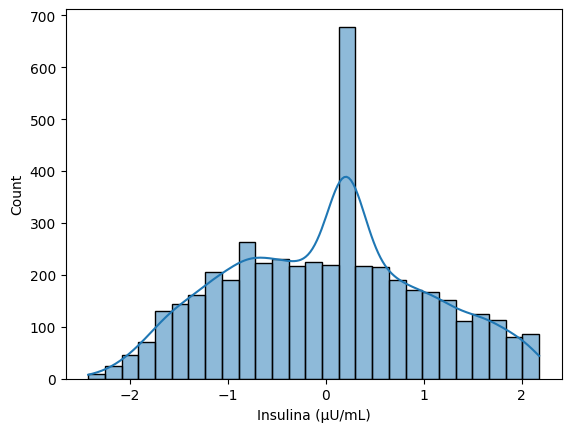

In [24]:
sns.histplot(data=insulina_limpia, x="Insulina (μU/mL)", kde=True)
plt.show()

In [25]:
Q1 = colesterol["Colesterol Total (mg/dL)"].quantile(0.25)
Q3 = colesterol["Colesterol Total (mg/dL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers_colesterol = colesterol[(colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (colesterol["Colesterol Total (mg/dL)"] > upper_bound)]

# Removing outliers
consideracion_colesterol_limpio = colesterol[~((colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (colesterol["Colesterol Total (mg/dL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers_colesterol)

print(num_outliers)

 El IQR es 52.0. El límite inferior es: 71.0, el superior es 279.0
177


In [26]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
colesterol_limpio = consideracion_colesterol_limpio.copy()
colesterol_limpio["Colesterol Total (mg/dL)"] = knn_imputer.fit_transform(colesterol_limpio[["Colesterol Total (mg/dL)"]])

[09/08/24 18:14:40] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=176269;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=532877;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

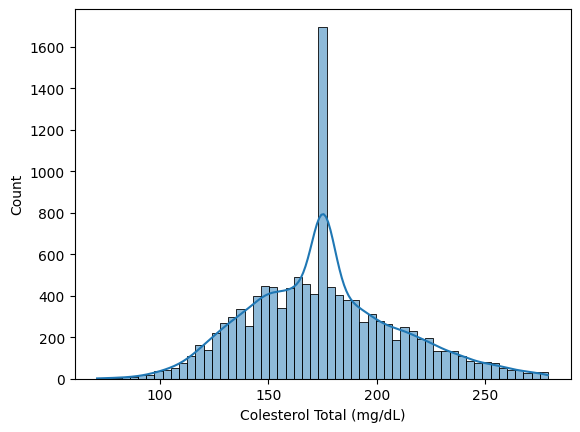

In [27]:
sns.histplot(data=colesterol_limpio, x="Colesterol Total (mg/dL)", kde=True)
plt.show()

In [28]:
colesterol_limpio["Colesterol Total (mg/dL)"] = pt.fit_transform(colesterol_limpio[["Colesterol Total (mg/dL)"]])

In [29]:
prueba = pd.DataFrame()
prueba["ID"] = consideracion["ID"]
prueba["Edad"] = consideracion["Edad"]
prueba["Raza"] = consideracion["Raza"]

In [30]:
merge_insulina = pd.merge(prueba, insulina_limpia, on='ID', how='inner')
merge_medidas = pd.merge(medidas, merge_insulina, on='ID', how='inner')
merge_presion = pd.merge(presion, merge_medidas, on='ID', how='inner')
final = pd.merge(merge_presion, colesterol_limpio, on='ID', how='inner')

In [31]:
final.columns[2:]


Index(['Tamaño del manguito codificado - oscilométrico',
       'Presión sistólica - 1ra lectura oscilométrica',
       'Presión diastólica - 1ra lectura oscilométrica',
       'Presión sistólica - 2da lectura oscilométrica',
       'Presión diastólica - 2da lectura oscilométrica',
       'Presión sistólica - 3ra lectura oscilométrica',
       'Presión diastólica - 3ra lectura oscilométrica',
       'Pulso - 1ra lectura oscilométrica',
       'Pulso - 2da lectura oscilométrica',
       'Pulso - 3ra lectura oscilométrica',
       'Código de estado del componente de medidas corporales', 'Peso (kg)',
       'Comentario sobre el peso', 'Longitud recumbente (cm)',
       'Comentario sobre la longitud recumbente',
       'Circunferencia de la cabeza (cm)',
       'Comentario sobre la circunferencia de la cabeza', 'Altura de pie (cm)',
       'Comentario sobre la altura de pie', 'Índice de masa corporal (kg/m²)',
       'Categoría de IMC - Niños/Jóvenes', 'Longitud del muslo (cm)',
       'C

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\matrix.py ]8;id=453526;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=57569;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             :260: FutureWarning: Format strings passed to MaskedConstant are                      
                             ignored, but in future may error or produce different behavior                        
                               annotation = ("{:" + self.fmt + "}").format(val)                                    
                                                                                                                   

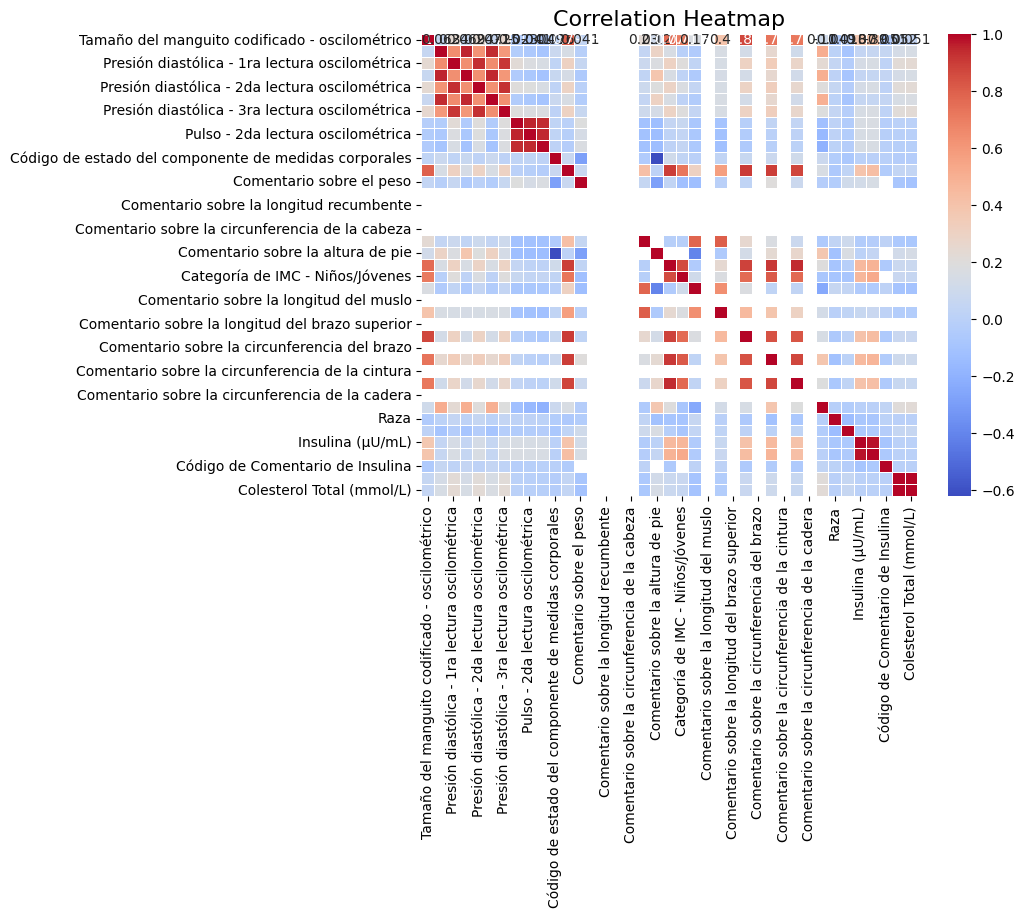

In [32]:
corr_matrix = final[final.columns[2:]].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [33]:

consideracion[consideracion["NivelPobreza"]<1]

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza
1     109264.00 13.00    2.00  1.00        NaN          NaN          0.83
6     109269.00  2.00    1.00  2.00        NaN          NaN          0.96
9     109272.00  0.00    1.00  1.00        NaN          NaN          0.73
10    109273.00 36.00    1.00  3.00       4.00         3.00          0.83
13    109276.00  0.00    1.00  4.00        NaN          NaN          0.00
...         ...   ...     ...   ...        ...          ...           ...
15524 124787.00 19.00    2.00  4.00        NaN          NaN          0.80
15529 124792.00 32.00    1.00  2.00       5.00         3.00          0.00
15535 124798.00 55.00    1.00  2.00       1.00         3.00          0.80
15543 124806.00  4.00    2.00  4.00        NaN          NaN          0.38
15556 124819.00  2.00    1.00  4.00        NaN          NaN          0.07

[3226 rows x 7 columns]

In [34]:
for columna in consideracion.columns:
    if consideracion[columna].isna().sum() != 0:
        print(f"Columna {columna} tiene {consideracion[columna].isna().sum()} NaN")

Columna Educacion tiene 6328 NaN
Columna EstadoCivil tiene 6328 NaN
Columna NivelPobreza tiene 2201 NaN


In [35]:
consideracion.loc[consideracion["Edad"] <= 13, "Educacion"] = consideracion.loc[consideracion["Edad"] <= 13, "Educacion"].fillna(1)
consideracion.loc[consideracion["Edad"] <= 19, "Educacion"] = consideracion.loc[consideracion["Edad"] <= 19, "Educacion"].fillna(2)
consideracion.loc[consideracion["Edad"] <= 18, "EstadoCivil"] = consideracion.loc[consideracion["Edad"] <= 18, "EstadoCivil"].fillna(3)

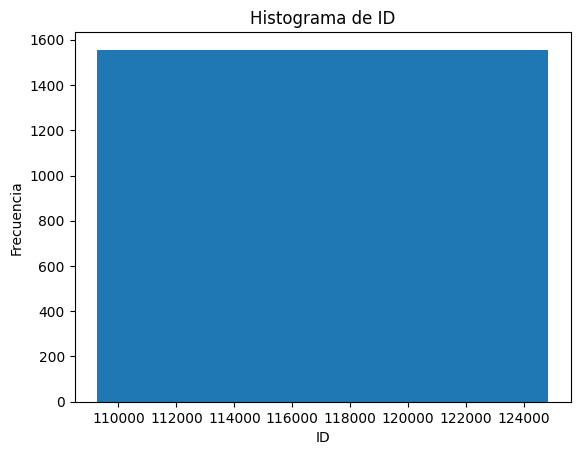

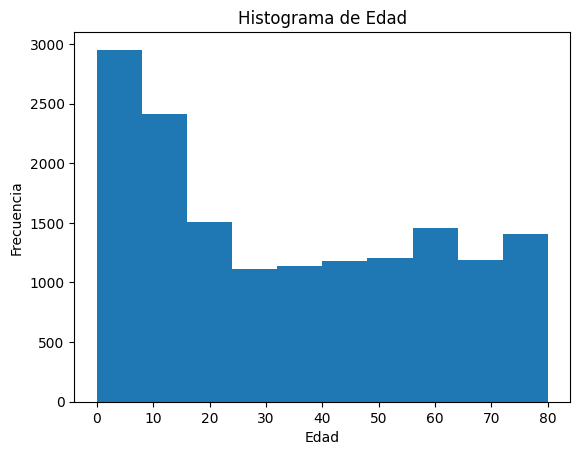

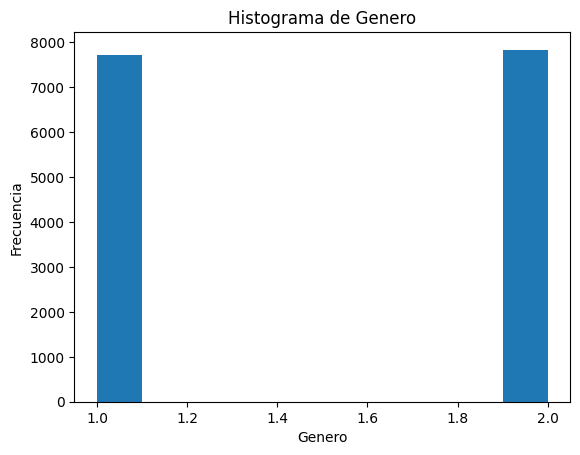

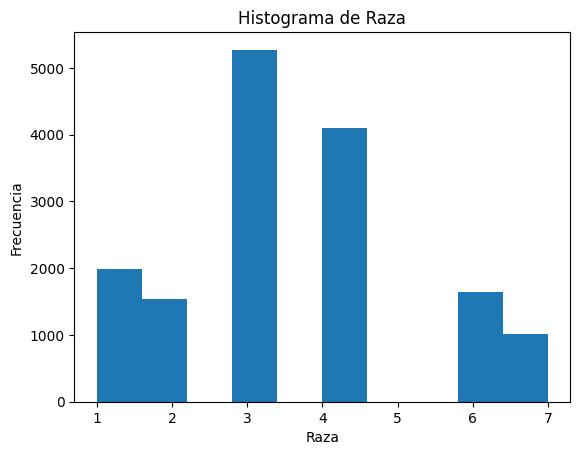

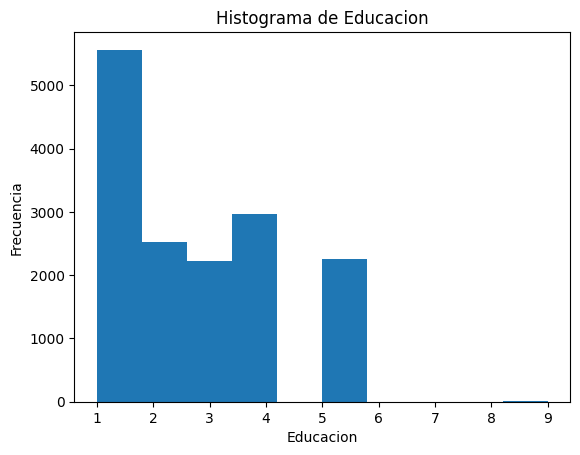

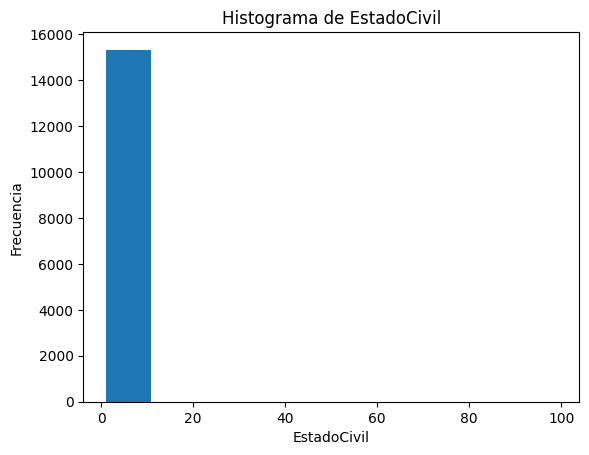

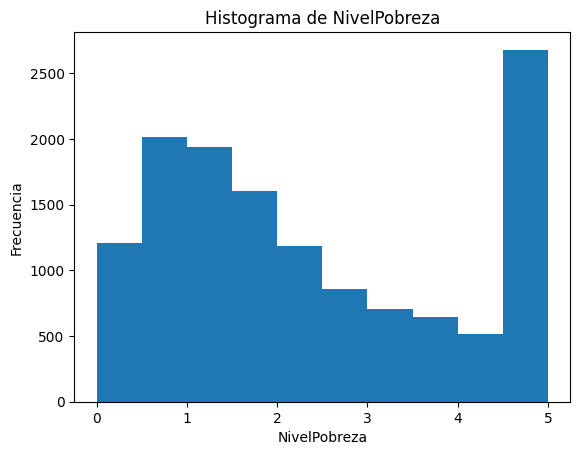

In [36]:
for col in consideracion.columns:
  plt.hist(consideracion[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [37]:
consideracion.isna().sum()


ID                 0
Edad               0
Genero             0
Raza               0
Educacion          0
EstadoCivil      227
NivelPobreza    2201
dtype: int64

In [38]:
consideracion = consideracion.loc[consideracion['NivelPobreza'] <5]

In [39]:
pobreza_escalado = scaler.fit_transform(consideracion[['NivelPobreza']])
pobreza_minmax = minmax.fit_transform(consideracion[['NivelPobreza']])
pobreza_pt = pt.fit_transform(consideracion[['NivelPobreza']])
pobreza_sqrt = np.sqrt(consideracion[['NivelPobreza']])
pobreza_boxcox, _ = stats.boxcox(consideracion["NivelPobreza"] + 1)
log_data = np.log1p(consideracion[['NivelPobreza']])

In [40]:
for pobre in [pobreza_boxcox,log_data,pobreza_escalado,pobreza_minmax,pobreza_pt,pobreza_sqrt]:
    df = pd.DataFrame(pobre)
    print(df.describe())

             0
count 11213.00
mean      1.03
std       0.50
min       0.00
25%       0.66
50%       1.02
75%       1.42
max       1.96
       NivelPobreza
count      11213.00
mean           0.97
std            0.45
min            0.00
25%            0.64
50%            0.97
75%            1.32
max            1.79
             0
count 11213.00
mean      0.00
std       1.00
min      -1.49
25%      -0.79
50%      -0.21
75%       0.65
max       2.39
             0
count 11213.00
mean      0.38
std       0.26
min       0.00
25%       0.18
50%       0.33
75%       0.55
max       1.00
             0
count 11213.00
mean      0.00
std       1.00
min      -2.08
25%      -0.74
50%      -0.02
75%       0.77
max       1.88
       NivelPobreza
count      11213.00
mean           1.29
std            0.50
min            0.00
25%            0.95
50%            1.28
75%            1.66
max            2.23


[09/08/24 18:14:41] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=666769;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=844879;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=871970;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=199739;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=690955;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=649608;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=57508;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=723426;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

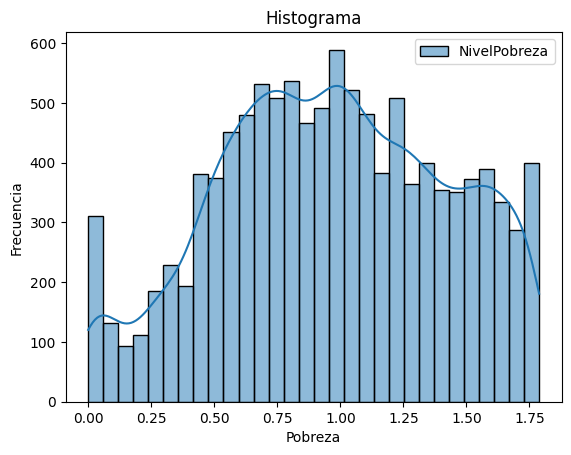

[09/08/24 18:14:42] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=649752;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=579330;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=481882;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=193749;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

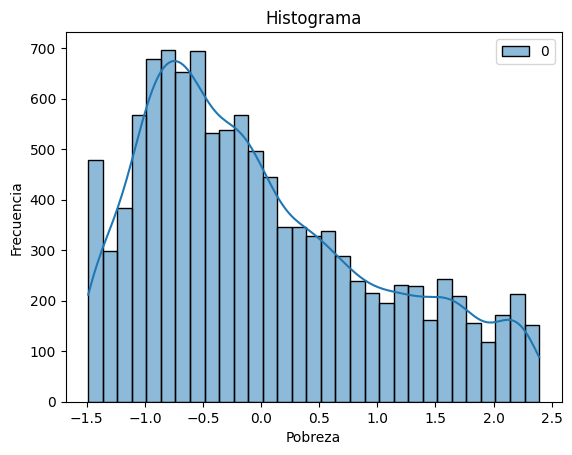

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=497552;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=85428;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=897340;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=661782;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

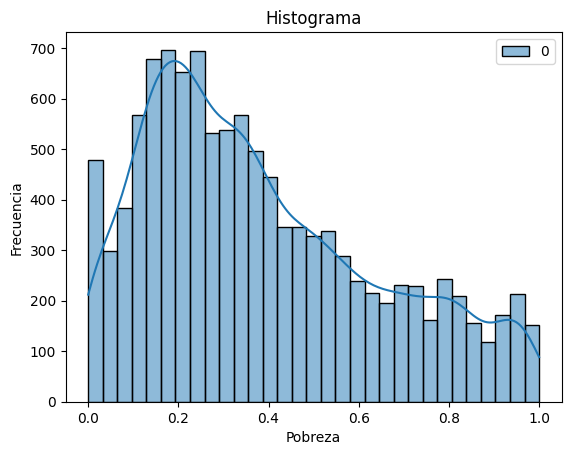

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=729338;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=236768;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=457181;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=744961;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

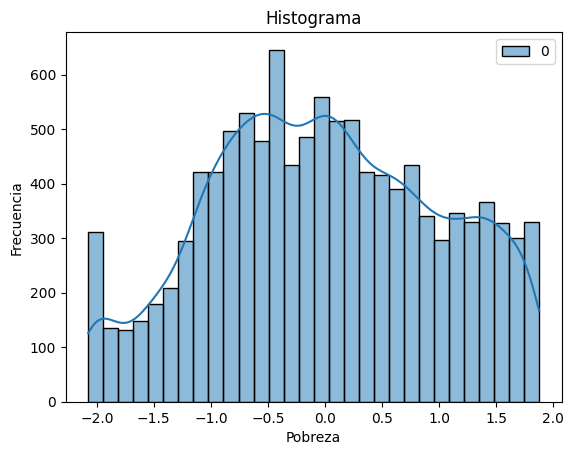

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=568271;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=311397;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=444935;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=359911;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=893048;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=375908;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=996433;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=402517;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

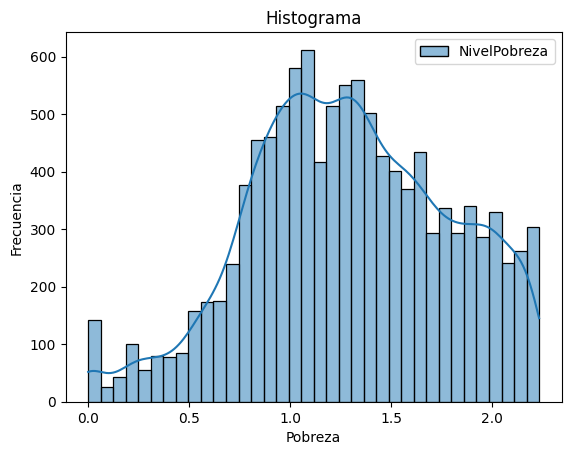

In [41]:
for pobre in [log_data,pobreza_escalado,pobreza_minmax,pobreza_pt,pobreza_sqrt]:
    sns.histplot(data=pobre, kde=True)
    plt.title(f'Histograma')
    plt.xlabel("Pobreza")
    plt.ylabel('Frecuencia')
    plt.show()

In [42]:
consideracion['NivelPobreza'] = pobreza_sqrt

In [43]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
consideracion['NivelPobreza'] = knn_imputer.fit_transform(pobreza_sqrt[['NivelPobreza']])
consideracion

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza
0     109263.00  2.00    1.00  6.00       1.00         3.00          2.16
1     109264.00 13.00    2.00  1.00       1.00         3.00          0.91
2     109265.00  2.00    1.00  3.00       1.00         3.00          1.75
5     109268.00 18.00    2.00  3.00       2.00         3.00          1.29
6     109269.00  2.00    1.00  2.00       1.00         3.00          0.98
...         ...   ...     ...   ...        ...          ...           ...
15554 124817.00 67.00    2.00  1.00       2.00         1.00          1.48
15555 124818.00 40.00    1.00  4.00       5.00         1.00          1.95
15556 124819.00  2.00    1.00  4.00       1.00         3.00          0.26
15557 124820.00  7.00    2.00  3.00       1.00         3.00          1.10
15558 124821.00 63.00    1.00  4.00       2.00         2.00          1.93

[11213 rows x 7 columns]

In [44]:
consideracion["NivelPobreza"].describe()


count   11213.00
mean        1.29
std         0.50
min         0.00
25%         0.95
50%         1.28
75%         1.66
max         2.23
Name: NivelPobreza, dtype: float64

In [45]:
consideracion.isna().sum()


ID                0
Edad              0
Genero            0
Raza              0
Educacion         0
EstadoCivil     173
NivelPobreza      0
dtype: int64

In [46]:
#consideracion = consideracion.dropna()

In [47]:
consideracion["Educacion"].isna().sum()

np.int64(0)

In [48]:
consideracion["NivelPobreza"].describe()


count   11213.00
mean        1.29
std         0.50
min         0.00
25%         0.95
50%         1.28
75%         1.66
max         2.23
Name: NivelPobreza, dtype: float64

# Combinación de dataset con Insulina

In [49]:
consideracion_insulina = pd.merge(consideracion, insulina, on='ID', how='inner')

In [50]:
consideracion_insulina.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  
count                           3307.00  
mean                               0.00  
std                                0.05  
min                                0.00  
25%                                0.00  
50%                                0.00  
75%                                0.00  
max                                1.00

In [51]:
Q1 = consideracion_insulina["Insulina (μU/mL)"].quantile(0.25)
Q3 = consideracion_insulina["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = consideracion_insulina[(consideracion_insulina["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
consideracion_insulina_limpio = consideracion_insulina[~((consideracion_insulina["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)


 El IQR es 10.659999999999998. El límite inferior es: -9.499999999999998, el superior es 33.14
227


In [52]:
Q1 = consideracion_insulina_limpio["Insulina (μU/mL)"].quantile(0.25)
Q3 = consideracion_insulina_limpio["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = consideracion_insulina_limpio[(consideracion_insulina_limpio["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina_limpio["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
insulina_limpio = consideracion_insulina_limpio[~((consideracion_insulina_limpio["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina_limpio["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 8.952499999999999. El límite inferior es: -7.188749999999997, el superior es 28.621249999999996
91


In [53]:
insulina_limpio.isna().sum()


ID                                    0
Edad                                  0
Genero                                0
Raza                                  0
Educacion                             0
EstadoCivil                          59
NivelPobreza                          0
Peso de Submuestra en Ayunas          0
Insulina (μU/mL)                    343
Insulina (pmol/L)                   343
Código de Comentario de Insulina    343
dtype: int64

In [54]:
insulina_limpio.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3332.00 3332.00 3332.00 3332.00    3332.00      3273.00       3332.00   
mean  117201.71   44.08    1.52    3.48       3.10         1.87          1.33   
std     4464.66   20.88    0.50    1.62       1.26         0.88          0.49   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113395.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117358.50   44.00    2.00    3.00       3.00         2.00          1.32   
75%   121054.00   62.00    2.00    4.00       4.00         3.00          1.69   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3332.00           2989.00            2989.00   
mean                       49067.66             10.94              65.66   
std                        61251.29              6.22              37.33   
min                            0.00              0.71               4.26   
25%                        16954.33              6.17              37.02   
50%                        31798.15              9.59              57.54   
75%                        57008.16             14.47              86.82   
max                       741259.19             28.51             171.06   

       Código de Comentario de Insulina  
count                           2989.00  
mean                               0.00  
std                                0.05  
min                                0.00  
25%                                0.00  
50%                                0.00  
75%                                0.00  
max                                1.00

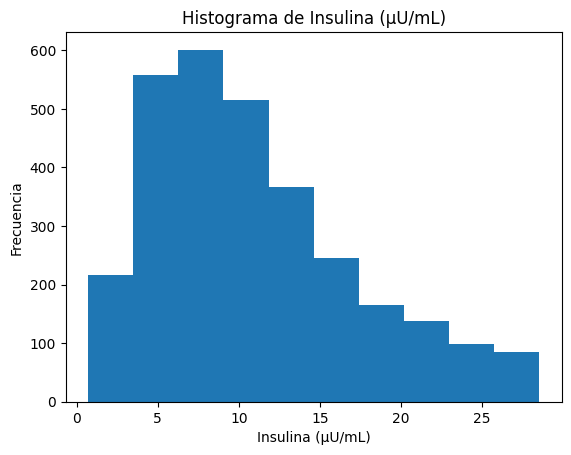

In [55]:
plt.hist(insulina_limpio["Insulina (μU/mL)"])
plt.title(f'Histograma de {"Insulina (μU/mL)"}')
plt.xlabel("Insulina (μU/mL)")
plt.ylabel('Frecuencia')
plt.show()

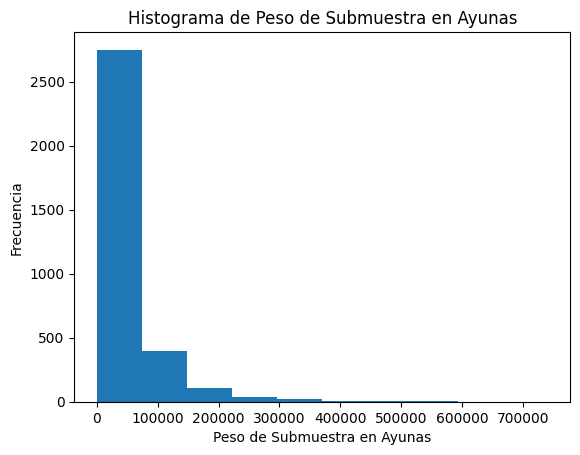

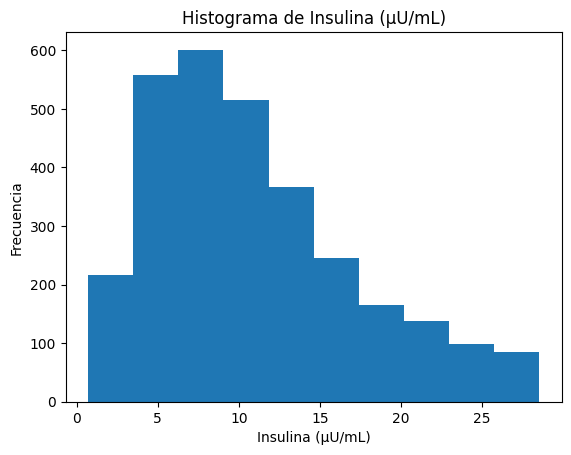

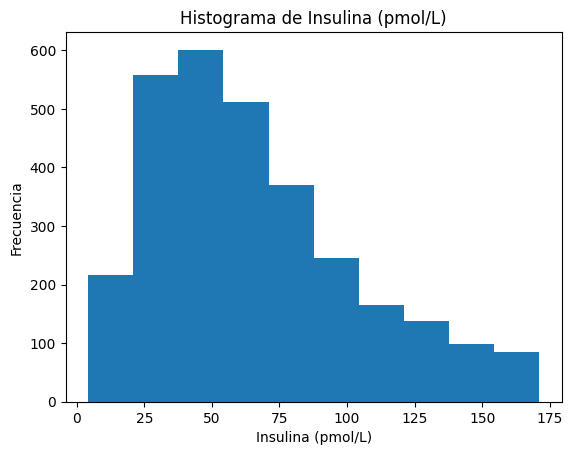

In [56]:
for col in insulina_limpio.columns[7:-1]:
  plt.hist(insulina_limpio[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [57]:
escalado = scaler.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])
minmaxesc = minmax.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])
powerTrans = pt.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])

In [58]:
insulina_escalado = insulina_limpio.copy()
insulina_minmax = insulina_limpio.copy()
insulina_power = insulina_limpio.copy()
insulina_escalado["Insulina (μU/mL)"]=escalado
insulina_minmax["Insulina (μU/mL)"]=minmaxesc
insulina_power["Insulina (μU/mL)"]=powerTrans

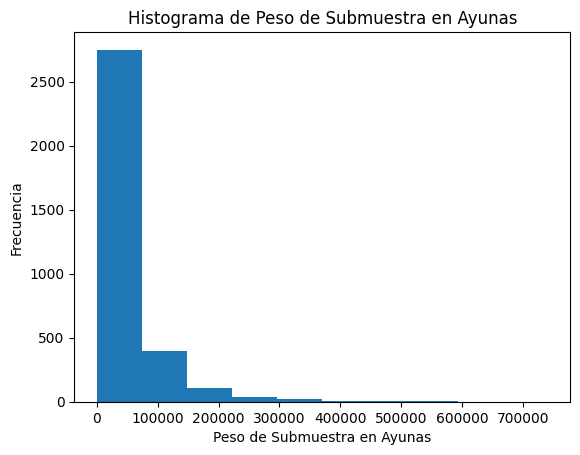

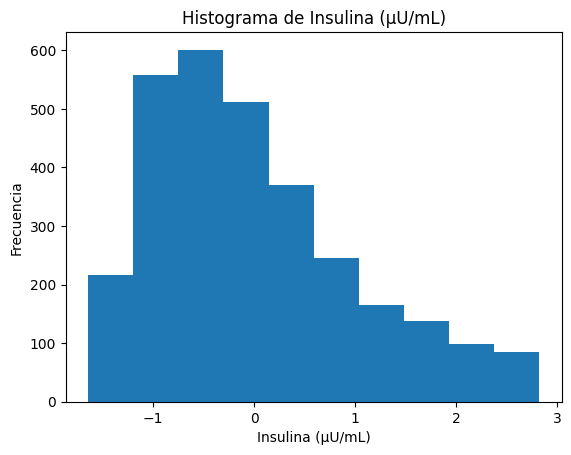

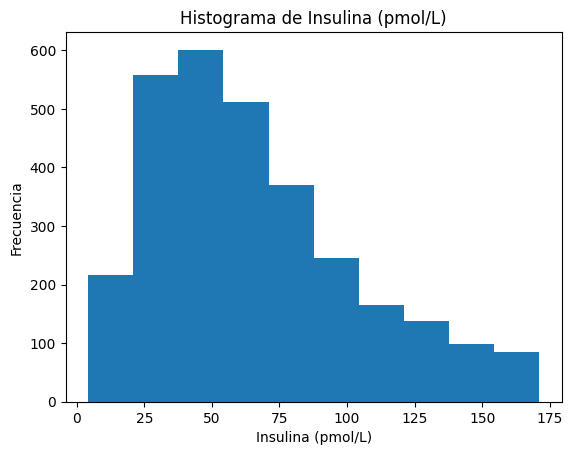

In [59]:
for col in insulina_escalado.columns[7:-1]:
  plt.hist(insulina_escalado[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

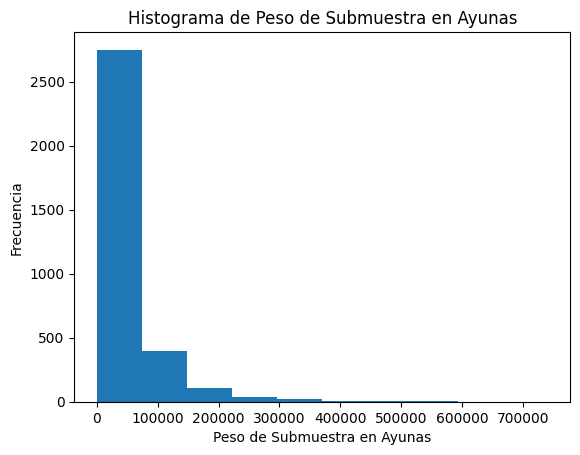

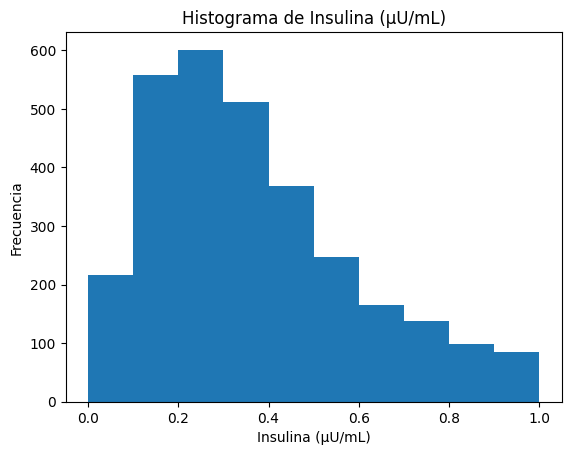

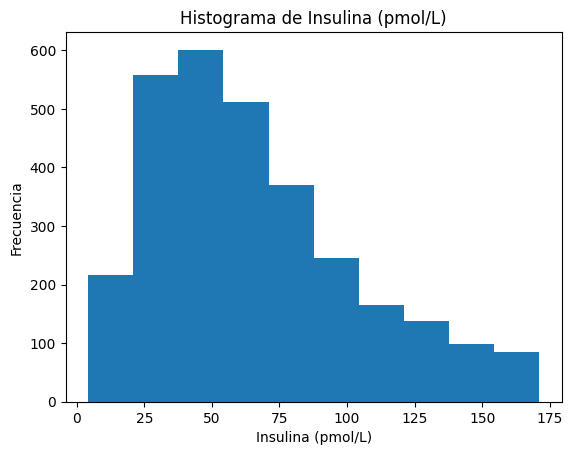

In [60]:
for col in insulina_minmax.columns[7:-1]:
  plt.hist(insulina_minmax[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [61]:
Q1 = insulina_escalado["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina_escalado["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina_escalado[(insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
limpieza_insulina = insulina_escalado[~((insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 1.3341734967127177. El límite inferior es: -2.7685061346628896, el superior es 2.5681878521879806
49


In [62]:
limp_ins = limpieza_insulina.copy()
limp_ins["Insulina (μU/mL)"] = pt.fit_transform(limp_ins[["Insulina (μU/mL)"]])

[09/08/24 18:14:44] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=555253;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=231138;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

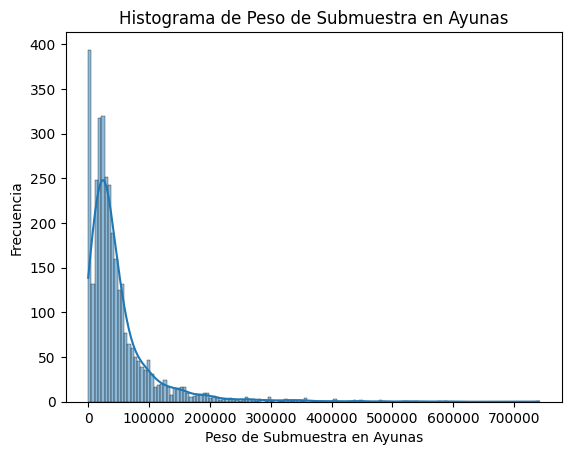

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=599525;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=570366;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

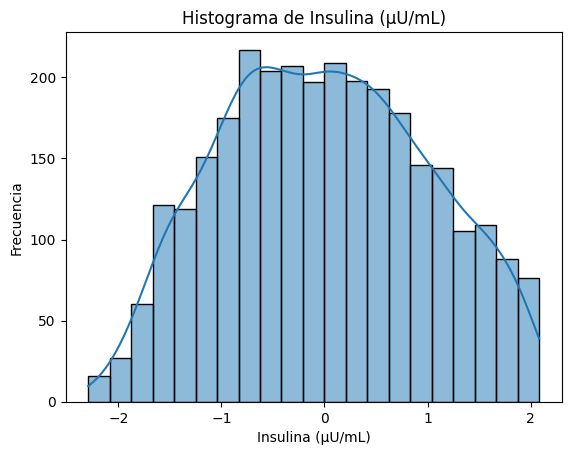

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=454753;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=891813;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

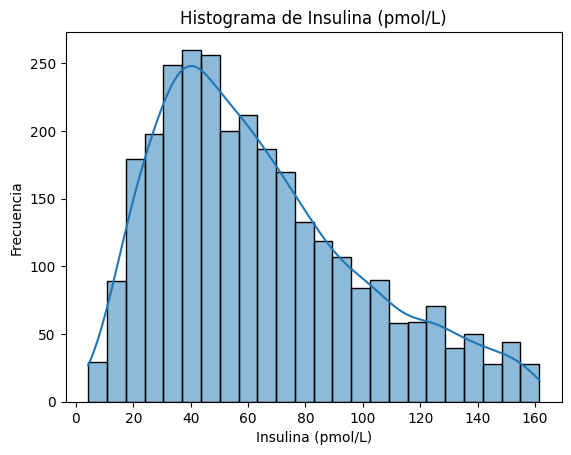

In [63]:
for col in insulina_power.columns[7:-1]:
  sns.histplot(data=limp_ins, x=col, kde=True)
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [64]:
limp_ins.isna().sum()


ID                                    0
Edad                                  0
Genero                                0
Raza                                  0
Educacion                             0
EstadoCivil                          59
NivelPobreza                          0
Peso de Submuestra en Ayunas          0
Insulina (μU/mL)                    343
Insulina (pmol/L)                   343
Código de Comentario de Insulina    343
dtype: int64

In [65]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
limp_ins["Insulina (μU/mL)"] = knn_imputer.fit_transform(limp_ins[["Insulina (μU/mL)"]])

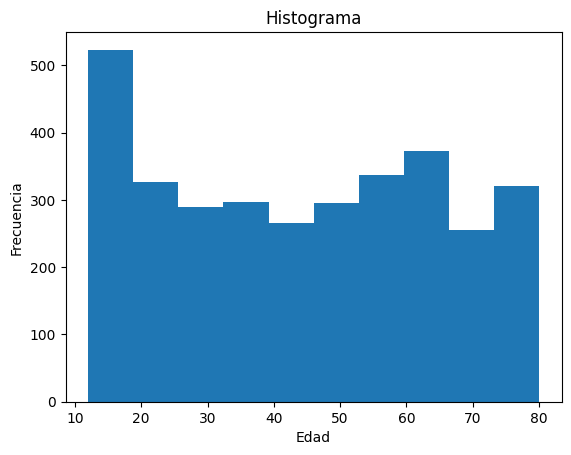

In [66]:
plt.hist(limp_ins["Edad"])
plt.title(f'Histograma')
plt.xlabel("Edad")
plt.ylabel('Frecuencia')
plt.show()

In [67]:

limp_ins["Edad"], lambda_opt = boxcox(limp_ins["Edad"] + 1)

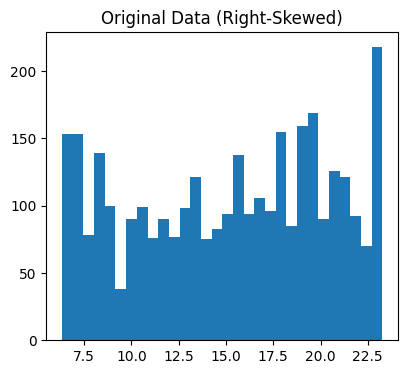

In [68]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(limp_ins["Edad"], bins=30)
plt.title('Original Data (Right-Skewed)')
plt.show()

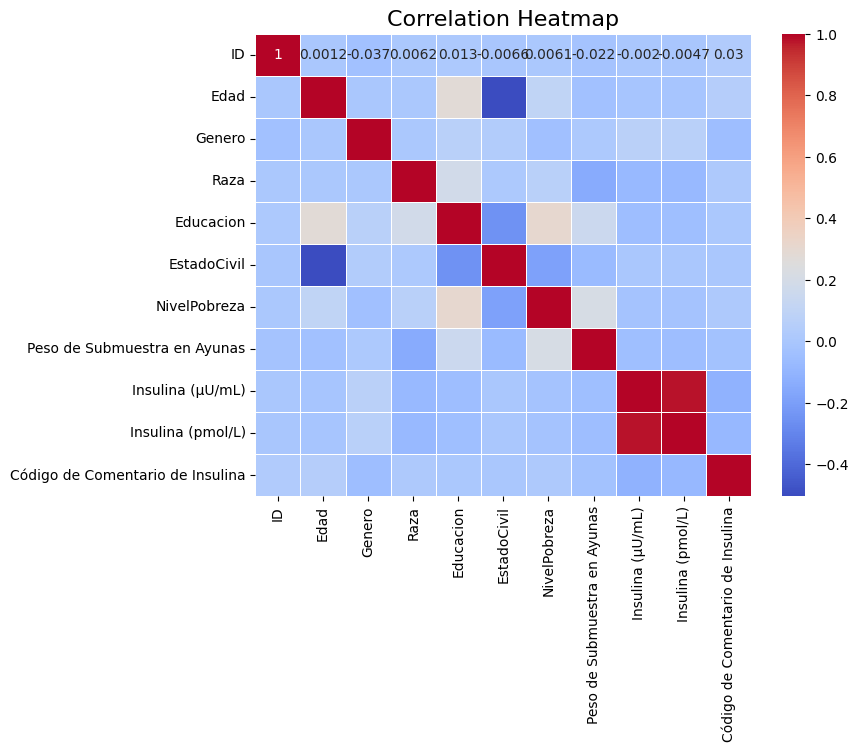

In [69]:
corr_matrix = limp_ins.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Conclusión: SIGUE SIN HABER RELACIÓN >:(

In [70]:
#insulina_nonna = consideracion_insulina.dropna()

# Combinación de Dataset con Colesterol

In [71]:
consideracion_colesterol = pd.merge(consideracion, colesterol, on='ID', how='inner')

In [72]:
consideracion_colesterol.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1 109270.00 11.00    2.00  4.00       1.00         3.00          1.37   
2 109273.00 36.00    1.00  3.00       4.00         3.00          0.91   
3 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
4 109275.00  6.00    1.00  3.00       1.00         3.00          1.93   

   Colesterol Total (mg/dL)  Colesterol Total (mmol/L)  
0                    166.00                       4.29  
1                    103.00                       2.66  
2                    164.00                       4.24  
3                    105.00                       2.72  
4                    167.00                       4.32

In [73]:
consideracion_colesterol.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   8850.00 8850.00 8850.00 8850.00    8850.00      8691.00       8850.00   
mean  117107.10   38.22    1.51    3.45       2.76         2.08          1.31   
std     4477.06   23.35    0.50    1.61       1.38         1.21          0.49   
min   109264.00    6.00    1.00    1.00       1.00         1.00          0.00   
25%   113263.50   16.00    1.00    3.00       1.00         1.00          0.97   
50%   117163.50   36.00    2.00    3.00       3.00         2.00          1.30   
75%   121016.75   59.00    2.00    4.00       4.00         3.00          1.67   
max   124821.00   80.00    2.00    7.00       9.00        77.00          2.23   

       Colesterol Total (mg/dL)  Colesterol Total (mmol/L)  
count                   7840.00                    7840.00  
mean                     176.14                       4.55  
std                       40.15                       1.04  
min                       73.00                       1.89  
25%                      148.00                       3.83  
50%                      171.00                       4.42  
75%                      200.00                       5.17  
max                      446.00                      11.53

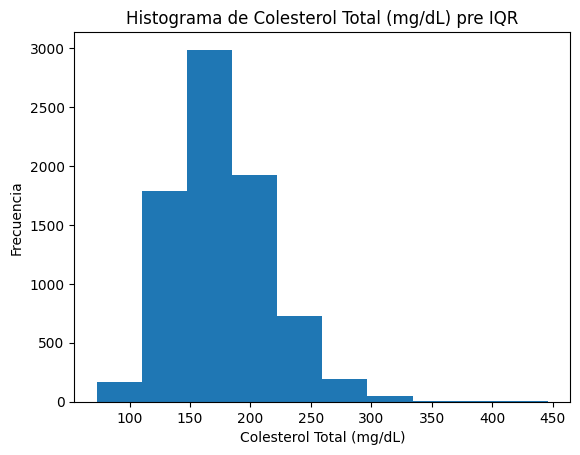

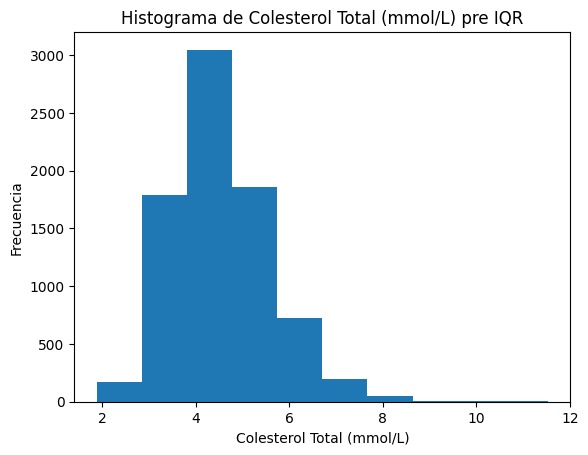

In [74]:
for col in consideracion_colesterol.columns[7:]:
  plt.hist(consideracion_colesterol[col])
  plt.title(f'Histograma de {col} pre IQR')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [75]:
Q1 = consideracion_colesterol["Colesterol Total (mg/dL)"].quantile(0.25)
Q3 = consideracion_colesterol["Colesterol Total (mg/dL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers_colesterol = consideracion_colesterol[(consideracion_colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (consideracion_colesterol["Colesterol Total (mg/dL)"] > upper_bound)]

# Removing outliers
consideracion_colesterol_limpio = consideracion_colesterol[~((consideracion_colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (consideracion_colesterol["Colesterol Total (mg/dL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers_colesterol)

print(num_outliers)

 El IQR es 52.0. El límite inferior es: 70.0, el superior es 278.0
133


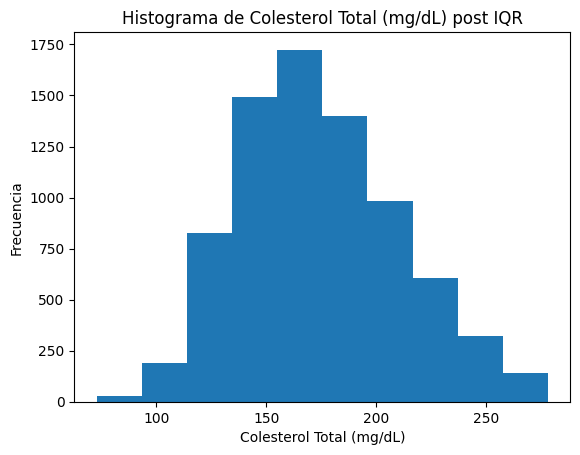

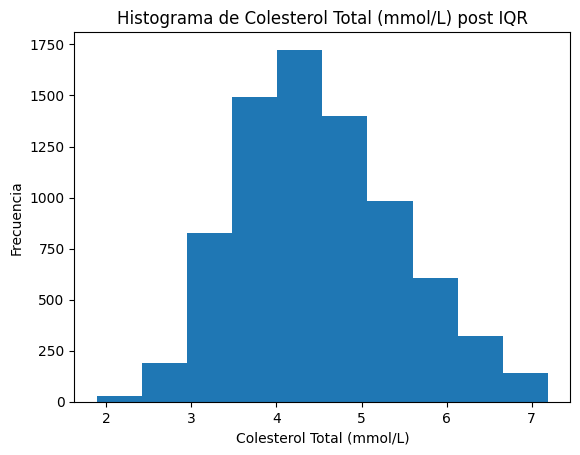

In [76]:
for col in consideracion_colesterol_limpio.columns[7:]:
  plt.hist(consideracion_colesterol_limpio[col])
  plt.title(f'Histograma de {col} post IQR')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

# Combinación de Dataset con Proteína C Spoiler: No pude lograr la distribución normal en la proteína :(

In [77]:
consideracion_proteinaC = pd.merge(consideracion, proteinaC, on='ID', how='inner')

In [78]:
consideracion_proteinaC.isna().sum()


ID                                                0
Edad                                              0
Genero                                            0
Raza                                              0
Educacion                                         0
EstadoCivil                                     159
NivelPobreza                                      0
Proteína C Reactiva (mg/L)                     1635
Código de Comentario de Proteína C Reactiva    1635
dtype: int64

In [79]:
consideracion_proteinaC.describe()

ID     Edad   Genero     Raza  Educacion  EstadoCivil  \
count  10086.00 10086.00 10086.00 10086.00   10086.00      9927.00   
mean  117117.73    33.88     1.51     3.45       2.54         2.20   
std     4483.25    24.77     0.50     1.61       1.41         1.17   
min   109263.00     1.00     1.00     1.00       1.00         1.00   
25%   113272.75    11.00     1.00     3.00       1.00         1.00   
50%   117187.50    29.00     2.00     3.00       2.00         3.00   
75%   121023.75    56.00     2.00     4.00       4.00         3.00   
max   124821.00    80.00     2.00     7.00       9.00        77.00   

       NivelPobreza  Proteína C Reactiva (mg/L)  \
count      10086.00                     8451.00   
mean           1.29                        3.50   
std            0.49                        7.75   
min            0.00                        0.11   
25%            0.95                        0.52   
50%            1.28                        1.35   
75%            1.66                        3.71   
max            2.23                      246.86   

       Código de Comentario de Proteína C Reactiva  
count                                      8451.00  
mean                                          0.04  
std                                           0.19  
min                                           0.00  
25%                                           0.00  
50%                                           0.00  
75%                                           0.00  
max                                           1.00

In [80]:
Q1 = consideracion_proteinaC["Proteína C Reactiva (mg/L)"].quantile(0.25)
Q3 = consideracion_proteinaC["Proteína C Reactiva (mg/L)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

outliers_proteinac = consideracion_proteinaC[(consideracion_proteinaC["Proteína C Reactiva (mg/L)"] < lower_bound) | (consideracion_proteinaC["Proteína C Reactiva (mg/L)"] > upper_bound)]

proteinac_limpio = consideracion_proteinaC[~((consideracion_proteinaC["Proteína C Reactiva (mg/L)"] < lower_bound) | (consideracion_proteinaC["Proteína C Reactiva (mg/L)"] > upper_bound))]

num_outliers = len(outliers_proteinac)

print(num_outliers)

 El IQR es 3.185. El límite inferior es: -1.0725, el superior es 5.2975
1471


In [81]:
proteina_c = proteinac_limpio.copy()
proteina_c[['Proteína C Reactiva (mg/L)']] = knn_imputer.fit_transform(proteina_c[['Proteína C Reactiva (mg/L)']])

In [82]:
proteina_c.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   8615.00 8615.00 8615.00 8615.00    8615.00      8481.00       8615.00   
mean  117090.00   31.97    1.49    3.48       2.45         2.25          1.30   
std     4469.56   24.86    0.50    1.63       1.42         1.21          0.50   
min   109263.00    1.00    1.00    1.00       1.00         1.00          0.00   
25%   113275.50   10.00    1.00    3.00       1.00         1.00          0.95   
50%   117149.00   25.00    1.00    3.00       2.00         3.00          1.28   
75%   120965.00   54.00    2.00    4.00       4.00         3.00          1.67   
max   124821.00   80.00    2.00    7.00       9.00        77.00          2.23   

       Proteína C Reactiva (mg/L)  Código de Comentario de Proteína C Reactiva  
count                     8615.00                                      6980.00  
mean                         1.47                                         0.05  
std                          1.18                                         0.21  
min                          0.11                                         0.00  
25%                          0.53                                         0.00  
50%                          1.41                                         0.00  
75%                          1.81                                         0.00  
max                          5.29                                         1.00

In [83]:
pro_c = proteina_c.copy()
pro_c["Proteína C Reactiva (mg/L)"] = minmax.fit_transform(pro_c[["Proteína C Reactiva (mg/L)"]])

[09/08/24 18:14:46] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=828895;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=730394;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

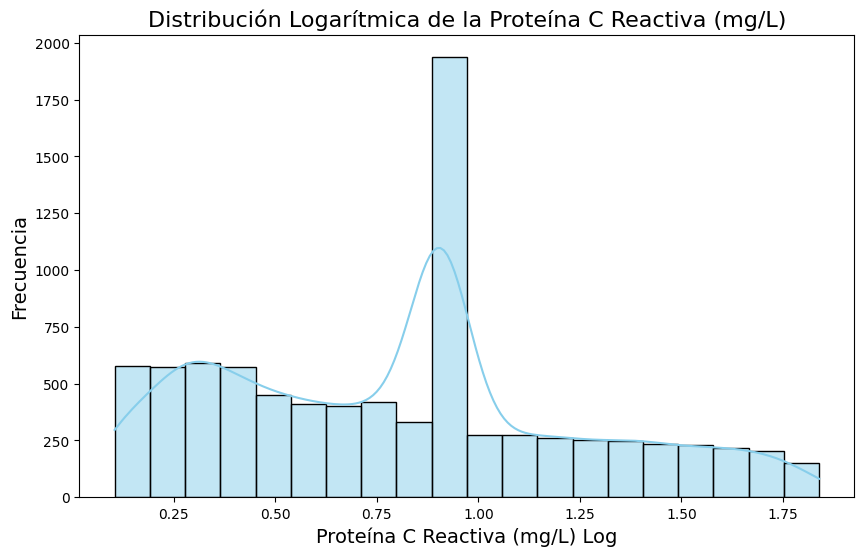

In [84]:
# Aplicar la transformación logarítmica
proteina_c['Proteína C Reactiva (mg/L) Log'] = np.log1p(proteina_c['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación logarítmica
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Log'].dropna(), bins=20, kde=True, color="skyblue")
plt.title('Distribución Logarítmica de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Log', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=43087;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=664189;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

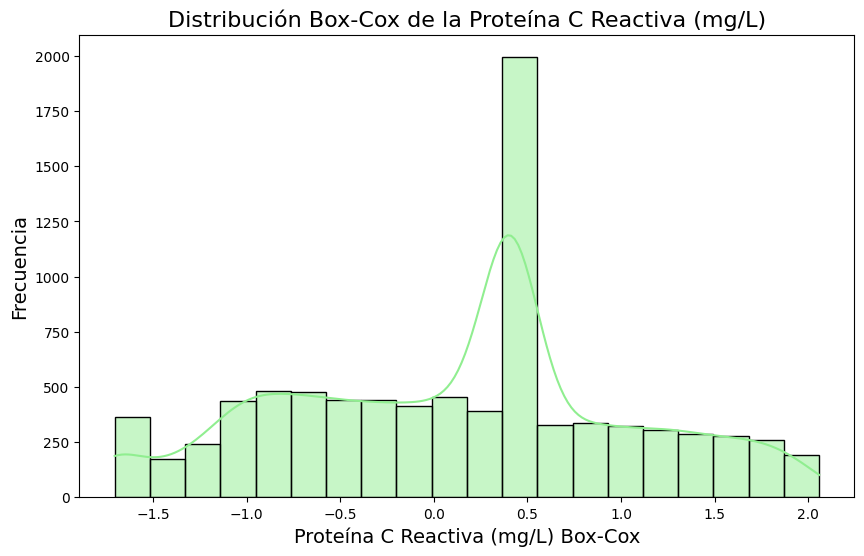

In [85]:
# Aplicar la transformación Box-Cox (requiere valores positivos)
proteina_c_positive = proteina_c[proteina_c['Proteína C Reactiva (mg/L)'] > 0]
proteina_c['Proteína C Reactiva (mg/L) Box-Cox'], _ = stats.boxcox(proteina_c_positive['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación Box-Cox
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Box-Cox'].dropna(), bins=20, kde=True, color="lightgreen")
plt.title('Distribución Box-Cox de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Box-Cox', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/08/24 18:14:47] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=884855;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=640000;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

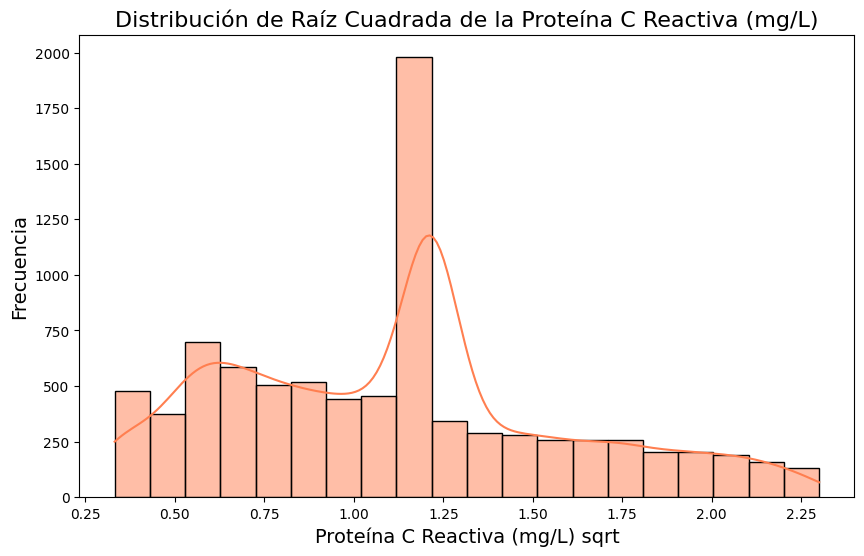

In [86]:
# Aplicar la transformación de raíz cuadrada
proteina_c['Proteína C Reactiva (mg/L) sqrt'] = np.sqrt(proteina_c['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación de raíz cuadrada
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) sqrt'].dropna(), bins=20, kde=True, color="coral")
plt.title('Distribución de Raíz Cuadrada de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) sqrt', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=628519;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=587801;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

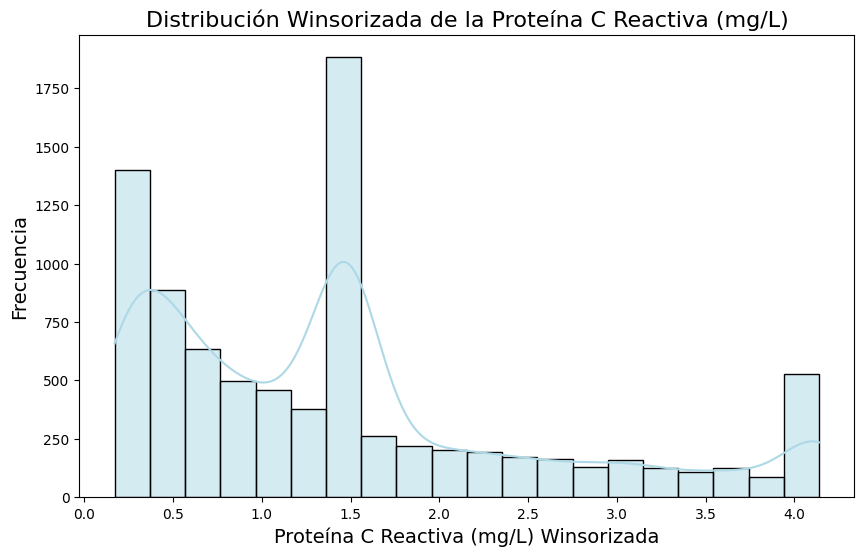

In [87]:
# Aplicar winsorización a los datos (cap los valores en el percentil 95)
proteina_c['Proteína C Reactiva (mg/L) Winsorizada'] = mstats.winsorize(proteina_c['Proteína C Reactiva (mg/L)'], limits=[0.05, 0.05])

# Visualizar la distribución después de la winsorización
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Winsorizada'].dropna(), bins=20, kde=True, color="lightblue")
plt.title('Distribución Winsorizada de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Winsorizada', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

# Combinación de Dataset con Depresión

In [88]:
consideracion_depresion = pd.merge(consideracion, depresion, on='ID', how='inner')

In [89]:
consideracion_depresion

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0    109273.00 36.00    1.00  3.00       4.00         3.00          0.91   
1    109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2    109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
3    109286.00 33.00    2.00  6.00       5.00         1.00          1.17   
4    109292.00 58.00    1.00  2.00       3.00         2.00          1.26   
...        ...   ...     ...   ...        ...          ...           ...   
6313 124810.00 56.00    2.00  4.00       4.00         3.00          1.39   
6314 124814.00 64.00    1.00  4.00       3.00         2.00          1.41   
6315 124817.00 67.00    2.00  1.00       2.00         1.00          1.48   
6316 124818.00 40.00    1.00  4.00       5.00         1.00          1.95   
6317 124821.00 63.00    1.00  4.00       2.00         2.00          1.93   

      Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
0                            2.00                                2.00   
1                            0.00                                0.00   
2                            0.00                                1.00   
3                             NaN                                 NaN   
4                            0.00                                3.00   
...                           ...                                 ...   
6313                         0.00                                0.00   
6314                         0.00                                0.00   
6315                         1.00                                1.00   
6316                         0.00                                0.00   
6317                         3.00                                0.00   

      Problemas para Dormir  Cansancio o Poca Energía  \
0                      2.00                      2.00   
1                      0.00                      0.00   
2                      0.00                      1.00   
3                       NaN                       NaN   
4                      0.00                      2.00   
...                     ...                       ...   
6313                   0.00                      1.00   
6314                   0.00                      0.00   
6315                   1.00                      1.00   
6316                   0.00                      1.00   
6317                   0.00                      2.00   

      Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
0                               2.00                              2.00   
1                               0.00                              0.00   
2                               0.00                              0.00   
3                                NaN                               NaN   
4                               0.00                              3.00   
...                              ...                               ...   
6313                            0.00                              0.00   
6314                            0.00                              0.00   
6315                            0.00                              0.00   
6316                            0.00                              0.00   
6317                            0.00                              0.00   

      Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
0                           2.00                                 1.00   
1                           0.00                                 0.00   
2                           0.00                                 3.00   
3                            NaN                                  NaN   
4                           0.00                                 0.00   
...                          ...                                  ...   
6313                        0.00                                 0.00   
6314                        0.00                                

In [90]:
consideracion_depresion.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   6318.00 6318.00 6318.00 6318.00    6318.00      6159.00       6318.00   
mean  117147.90   49.03    1.52    3.44       3.34         1.71          1.34   
std     4479.07   18.73    0.50    1.56       1.17         1.26          0.48   
min   109273.00   18.00    1.00    1.00       1.00         1.00          0.00   
25%   113321.25   33.00    1.00    3.00       3.00         1.00          1.00   
50%   117180.50   50.00    2.00    3.00       3.00         1.00          1.32   
75%   121072.50   64.00    2.00    4.00       4.00         2.00          1.70   
max   124821.00   80.00    2.00    7.00       9.00        77.00          2.23   

       Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
count                      5870.00                             5869.00   
mean                          0.42                                0.40   
std                           0.81                                0.77   
min                           0.00                                0.00   
25%                           0.00                                0.00   
50%                           0.00                                0.00   
75%                           1.00                                1.00   
max                           9.00                                9.00   

       Problemas para Dormir  Cansancio o Poca Energía  \
count                5869.00                   5869.00   
mean                    0.70                      0.80   
std                     1.02                      0.98   
min                     0.00                      0.00   
25%                     0.00                      0.00   
50%                     0.00                      1.00   
75%                     1.00                      1.00   
max                     9.00                      9.00   

       Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
count                         5869.00                           5868.00   
mean                             0.44                              0.28   
std                              0.85                              0.69   
min                              0.00                              0.00   
25%                              0.00                              0.00   
50%                              0.00                              0.00   
75%                              1.00                              0.00   
max                              9.00                              9.00   

       Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
count                     5868.00                              5868.00   
mean                         0.30                                 0.19   
std                          0.75                                 0.62   
min                          0.00                                 0.00   
25%                          0.00                                 0.00   
50%                          0.00                                 0.00   
75%                          0.00                                 0.00   
max                          9.00                                 9.00   

       Pensamientos de Muerte o Autolesión  \
count                              5866.00   
mean                                  0.06   
std                                   0.36   
min                                   0.00   
25%                                   0.00   
50%                                   0.00   
75%                                   0.00   
max                                   9.00   

       Dificultad que Estos Problemas Causan  
count                                4015.00  
mean                                    0.36  
std                                     0.66  
min                                     0.00  
25%                                     0.00  
50%                                     0.00  
75%   

In [91]:
def detectar_outliers_zscore(df, columna, umbral=3):
    z_scores = np.abs(stats.zscore(df[columna].dropna()))
    z_scores_series = pd.Series(z_scores, index=df[columna].dropna().index)
    outliers = df.loc[z_scores_series[z_scores_series > umbral].index]
    return outliers
    
outliers_zscore = detectar_outliers_zscore(depresion, 'Poco Interés en Hacer Cosas')
display(outliers_zscore)

ID  Poco Interés en Hacer Cosas  \
94   109459.00                         3.00   
131  109530.00                         3.00   
145  109551.00                         3.00   
190  109630.00                         3.00   
214  109673.00                         3.00   
...        ...                          ...   
8838 124615.00                         3.00   
8879 124690.00                         3.00   
8901 124726.00                         3.00   
8908 124737.00                         3.00   
8963 124821.00                         3.00   

      Sentirse Deprimido o Sin Esperanza  Problemas para Dormir  \
94                                  0.00                   2.00   
131                                 1.00                   1.00   
145                                 1.00                   1.00   
190                                 1.00                   0.00   
214                                 3.00                   3.00   
...                                  ...                    ...   
8838                                2.00                   3.00   
8879                                2.00                   1.00   
8901                                3.00                   3.00   
8908                                0.00                   1.00   
8963                                0.00                   0.00   

      Cansancio o Poca Energía  Poco Apetito o Comer en Exceso  \
94                        3.00                            3.00   
131                       1.00                            2.00   
145                       2.00                            0.00   
190                       3.00                            0.00   
214                       2.00                            2.00   
...                        ...                             ...   
8838                      3.00                            2.00   
8879                      3.00                            0.00   
8901                      3.00                            3.00   
8908                      2.00                            3.00   
8963                      2.00                            0.00   

      Sentirse Mal Acerca de Uno Mismo  Problemas de Concentración  \
94                                1.00                        1.00   
131                               0.00                        2.00   
145                               3.00                        2.00   
190                               0.00                        0.00   
214                               3.00                        3.00   
...                                ...                         ...   
8838                              1.00                        3.00   
8879                              0.00                        0.00   
8901                              3.00                        2.00   
8908                              0.00                        1.00   
8963                              0.00                        0.00   

      Movimientos o Hablar Lento o Rápido  \
94                                   1.00   
131                                  0.00   
145                                  2.00   
190                                  1.00   
214                                  3.00   
...                                   ...   
8838                                 3.00   
8879                                 0.00   
8901                                 0.00   
8908                                 0.00   
8963                                 0.00   

      Pensamientos de Muerte o Autolesión  \
94                                   0.00   
131                                  0.00   
145                                  0.00   
190                                  0.00   
214                                  0.00   
...                                   ...   
8838                                 0.00   
8879                                 0.00   
8901                                 3.00   
8908             

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=332579;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=457143;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

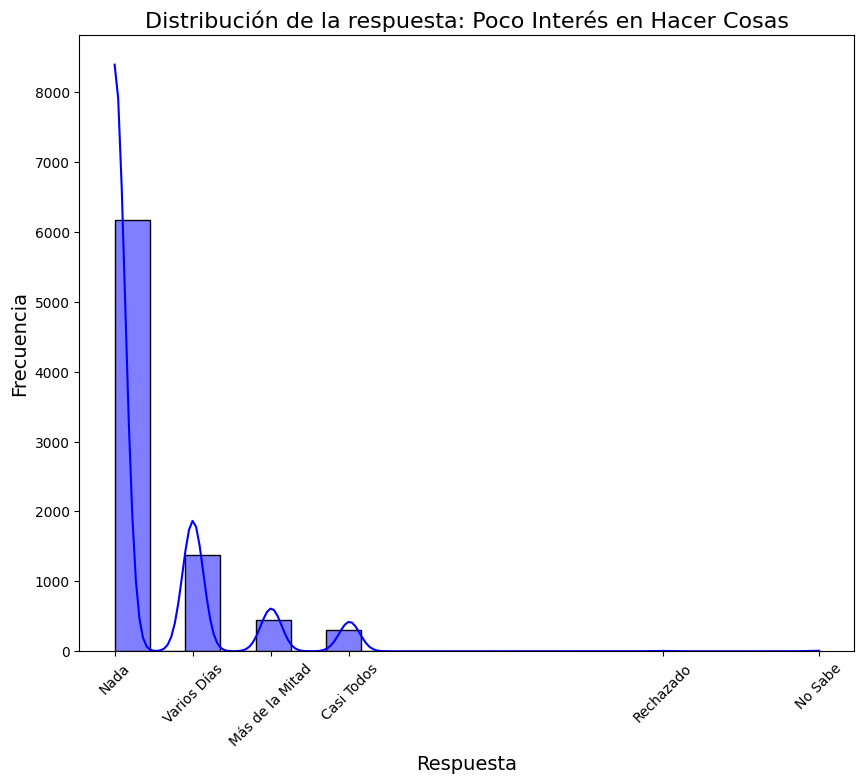

In [92]:
# Histograma de la columna 'Poca Interés en Hacer Cosas'
plt.figure(figsize=(10, 8))
sns.histplot(depresion['Poco Interés en Hacer Cosas'].dropna(), bins=20, kde=True, color="blue")
plt.title('Distribución de la respuesta: Poco Interés en Hacer Cosas', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(ticks=[0, 1, 2, 3, 7, 9], labels=['Nada', 'Varios Días', 'Más de la Mitad', 'Casi Todos', 'Rechazado', 'No Sabe'])
plt.xticks(rotation=45)  # Rota las etiquetas del eje X 45 grados
plt.show()

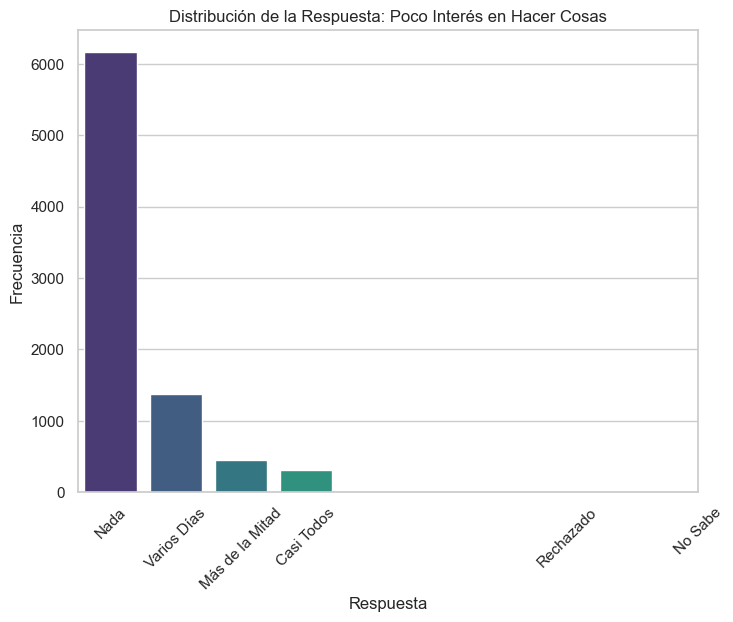

In [93]:
sns.set(style="whitegrid")

# Pregunta 1: Distribución para 'Poca Interés en Hacer Cosas' (DPQ010)
plt.figure(figsize=(8, 6))
sns.countplot(x='Poco Interés en Hacer Cosas', data=depresion, palette="viridis")
plt.title('Distribución de la Respuesta: Poco Interés en Hacer Cosas')
plt.xlabel('Respuesta')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1, 2, 3, 7, 9], labels=['Nada', 'Varios Días', 'Más de la Mitad', 'Casi Todos', 'Rechazado', 'No Sabe'])
plt.xticks(rotation=45)  # Rota las etiquetas del eje X 45 grados
plt.show()

[09/08/24 18:14:48] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=920957;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=725871;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

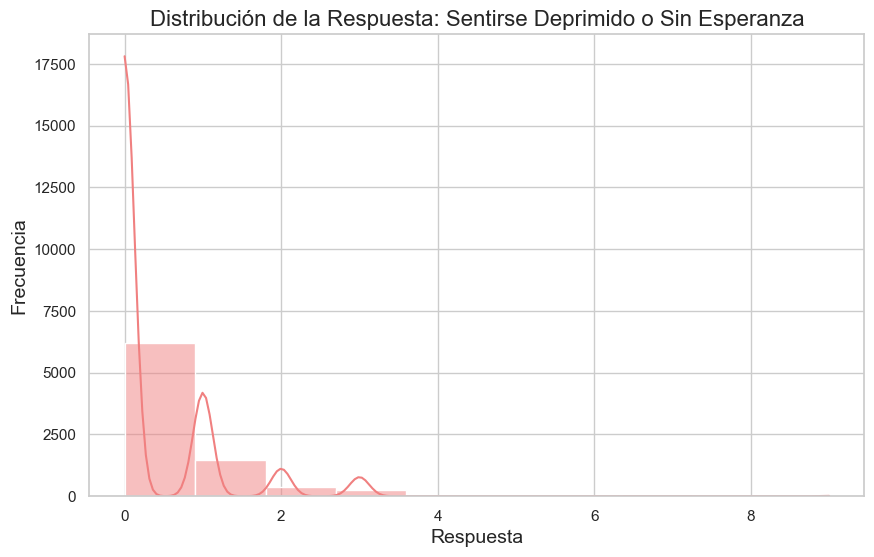

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Deprimido o Sin Esperanza'].dropna(), bins=10, kde=True, color="lightcoral")
plt.title('Distribución de la Respuesta: Sentirse Deprimido o Sin Esperanza', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=160183;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=30190;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

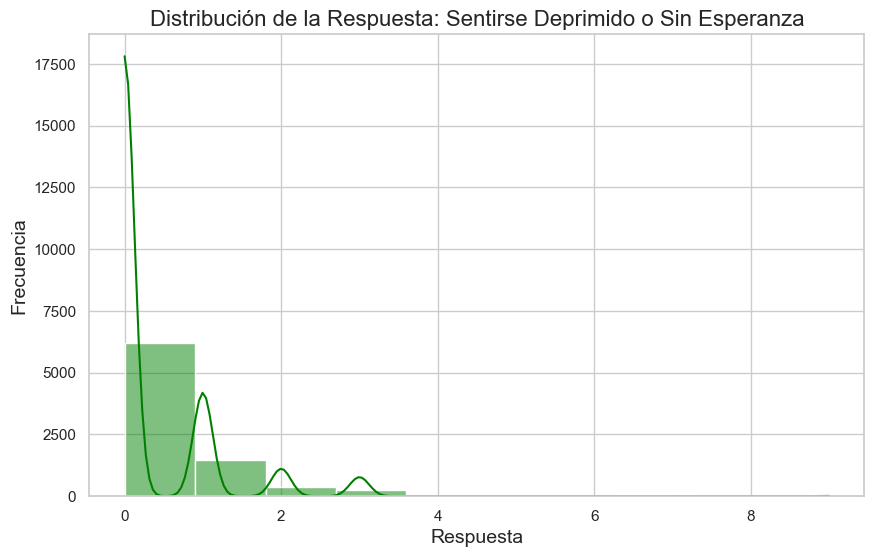

In [95]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Deprimido o Sin Esperanza'].dropna(), bins=10, kde=True, color="green")
plt.title('Distribución de la Respuesta: Sentirse Deprimido o Sin Esperanza', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=920611;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=415836;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

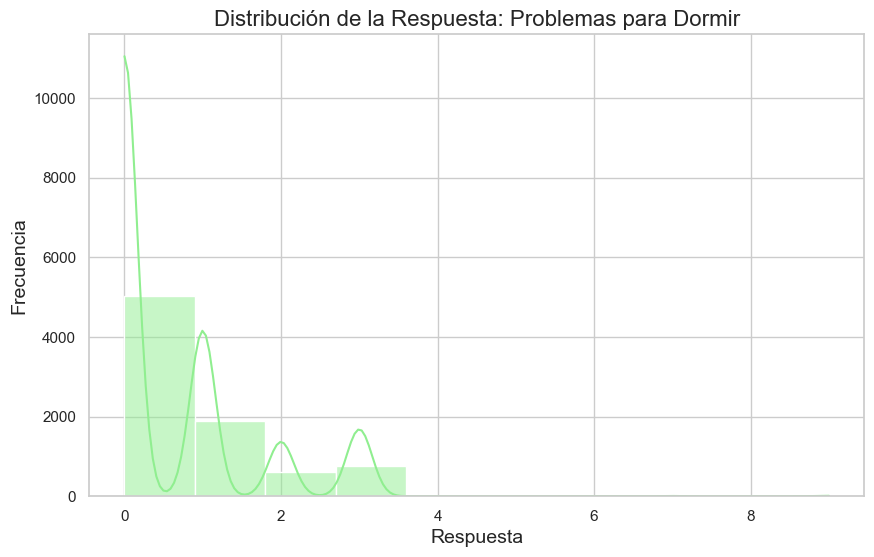

In [96]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Problemas para Dormir'].dropna(), bins=10, kde=True, color="lightgreen")
plt.title('Distribución de la Respuesta: Problemas para Dormir', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=591507;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=831909;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

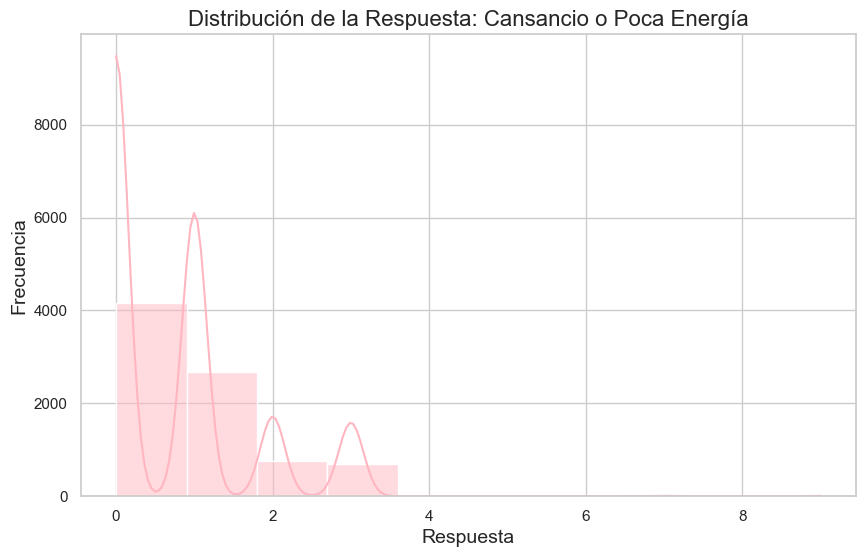

In [97]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Cansancio o Poca Energía'].dropna(), bins=10, kde=True, color="lightpink")
plt.title('Distribución de la Respuesta: Cansancio o Poca Energía', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=559602;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=637649;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

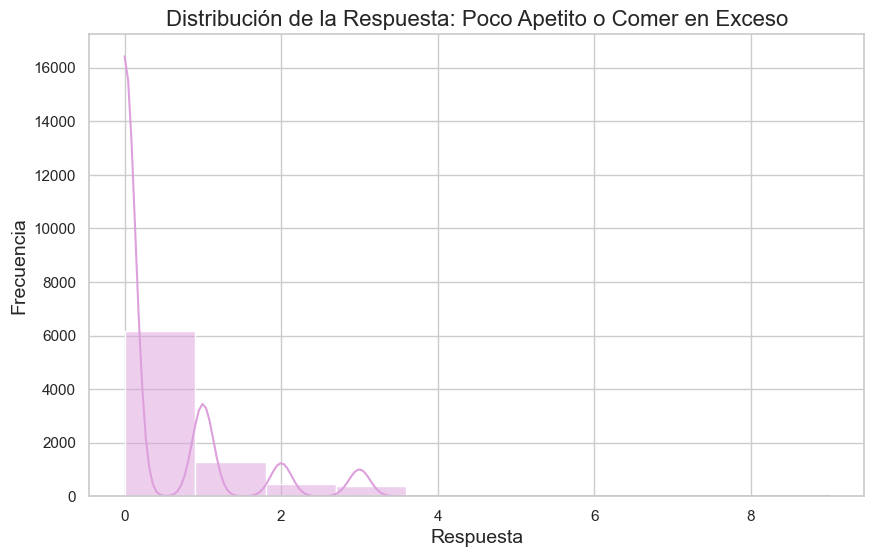

In [98]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Poco Apetito o Comer en Exceso'].dropna(), bins=10, kde=True, color="plum")
plt.title('Distribución de la Respuesta: Poco Apetito o Comer en Exceso', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/08/24 18:14:49] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=459215;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=879043;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

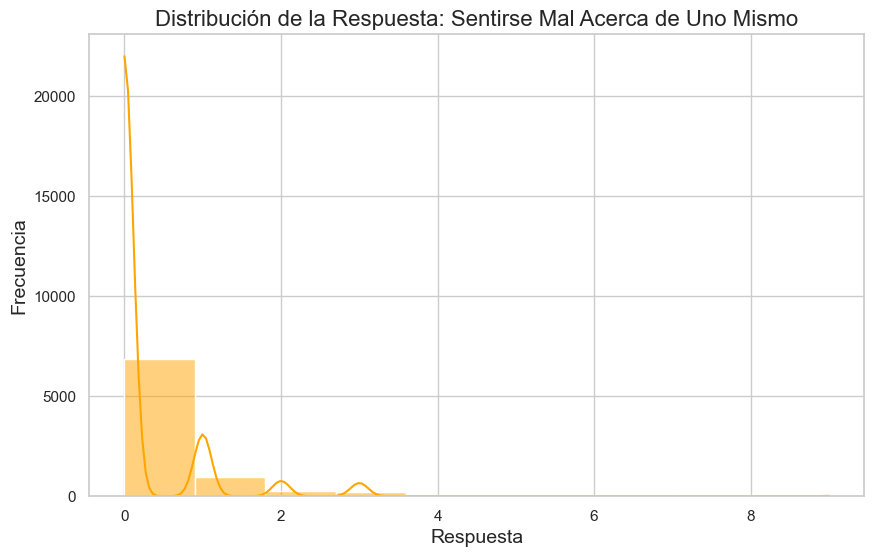

In [99]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Mal Acerca de Uno Mismo'].dropna(), bins=10, kde=True, color="orange")
plt.title('Distribución de la Respuesta: Sentirse Mal Acerca de Uno Mismo', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=933193;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=327736;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

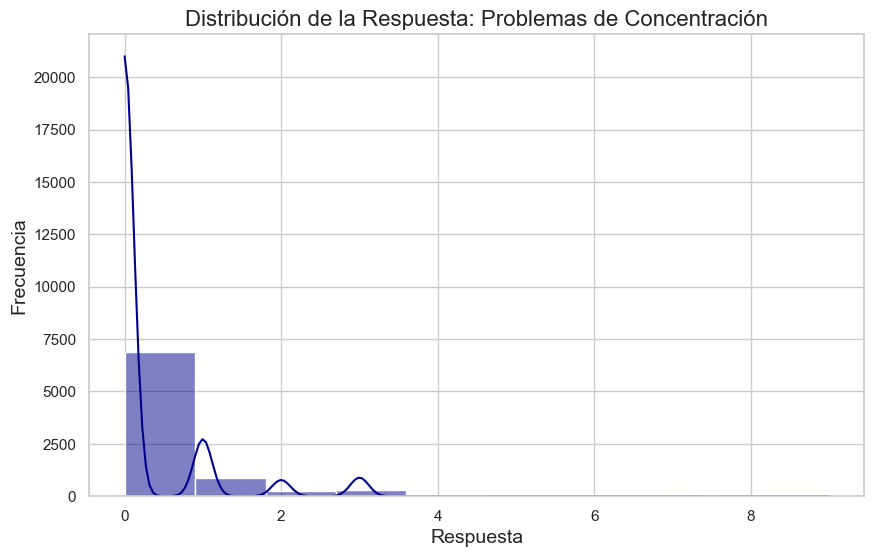

In [100]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Problemas de Concentración'].dropna(), bins=10, kde=True, color="darkblue")
plt.title('Distribución de la Respuesta: Problemas de Concentración', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=284767;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=997394;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

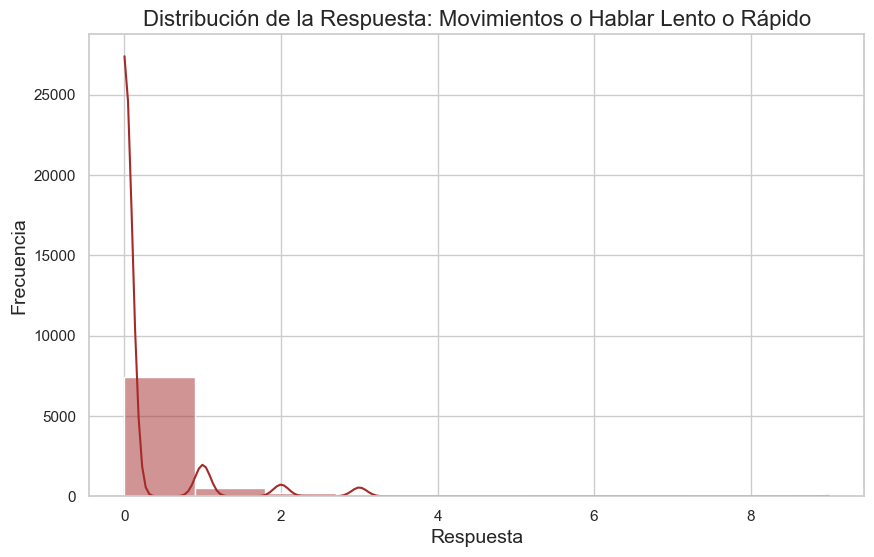

In [101]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Movimientos o Hablar Lento o Rápido'].dropna(), bins=10, kde=True, color="brown")
plt.title('Distribución de la Respuesta: Movimientos o Hablar Lento o Rápido', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=381891;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=559782;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

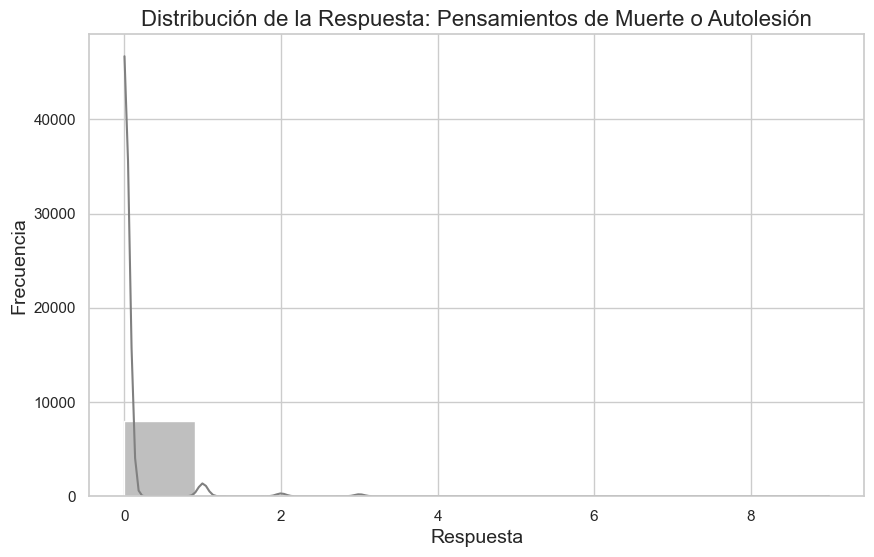

In [102]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Pensamientos de Muerte o Autolesión'].dropna(), bins=10, kde=True, color="grey")
plt.title('Distribución de la Respuesta: Pensamientos de Muerte o Autolesión', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [103]:
df= pd.merge(consideracion, insulina, on='ID', how='inner')

In [104]:
df.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2 109277.00 12.00    2.00  1.00       1.00         3.00          1.16   
3 109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
4 109286.00 33.00    2.00  6.00       5.00         1.00          1.17   

   Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
0                      27533.17              6.05              36.30   
1                      16281.76             13.52              81.12   
2                      32230.05              6.44              38.64   
3                      79007.10              7.49              44.94   
4                          0.00             16.46              98.76   

   Código de Comentario de Insulina  
0                              0.00  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [105]:
df.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  
count                           3307.00  
mean                               0.00  
std                                0.05  
min                                0.00  
25%                                0.00  
50%                                0.00  
75%                                0.00  
max                                1.00

In [106]:
df2= pd.merge(df, colesterol, on='ID', how='inner')

In [107]:
df2.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2 109277.00 12.00    2.00  1.00       1.00         3.00          1.16   
3 109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
4 109286.00 33.00    2.00  6.00       5.00         1.00          1.17   

   Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
0                      27533.17              6.05              36.30   
1                      16281.76             13.52              81.12   
2                      32230.05              6.44              38.64   
3                      79007.10              7.49              44.94   
4                          0.00             16.46              98.76   

   Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
0                              0.00                    166.00   
1                              0.00                    105.00   
2                              0.00                    129.00   
3                              0.00                    233.00   
4                              0.00                    236.00   

   Colesterol Total (mmol/L)  
0                       4.29  
1                       2.72  
2                       3.34  
3                       6.03  
4                       6.10

In [108]:
df2.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
count                           3307.00                   3336.00   
mean                               0.00                    178.22   
std                                0.05                     40.87   
min                                0.00                     73.00   
25%                                0.00                    150.00   
50%                                0.00                    173.00   
75%                                0.00                    202.00   
max                                1.00                    446.00   

       Colesterol Total (mmol/L)  
count                    3336.00  
mean                        4.61  
std                         1.06  
min                         1.89  
25%                         3.88  
50%                         4.47  
75%                         5.22  
max                        11.53

In [109]:
df3= pd.merge(df2, proteinaC, on='ID', how='inner')

In [110]:
df3

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0    109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1    109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2    109277.00 12.00    2.00  1.00       1.00         3.00          1.16   
3    109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
4    109286.00 33.00    2.00  6.00       5.00         1.00          1.17   
...        ...   ...     ...   ...        ...          ...           ...   
3645 124799.00 80.00    2.00  3.00       3.00         2.00          1.29   
3646 124803.00 46.00    2.00  1.00       4.00         2.00          1.17   
3647 124810.00 56.00    2.00  4.00       4.00         3.00          1.39   
3648 124814.00 64.00    1.00  4.00       3.00         2.00          1.41   
3649 124821.00 63.00    1.00  4.00       2.00         2.00          1.93   

      Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
0                         27533.17              6.05              36.30   
1                         16281.76             13.52              81.12   
2                         32230.05              6.44              38.64   
3                         79007.10              7.49              44.94   
4                             0.00             16.46              98.76   
...                            ...               ...                ...   
3645                      67466.96              4.33              25.98   
3646                      51646.77             16.97             101.82   
3647                      15125.62             20.12             120.72   
3648                       9339.90              7.27              43.62   
3649                      10704.47              7.75              46.50   

      Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
0                                 0.00                    166.00   
1                                 0.00                    105.00   
2                                 0.00                    129.00   
3                                 0.00                    233.00   
4                                 0.00                    236.00   
...                                ...                       ...   
3645                              0.00                    183.00   
3646                              0.00                    159.00   
3647                              0.00                    211.00   
3648                              0.00                    225.00   
3649                              0.00                    155.00   

      Colesterol Total (mmol/L)  Proteína C Reactiva (mg/L)  \
0                          4.29                        0.11   
1                          2.72                        1.60   
2                          3.34                        2.46   
3                          6.03                        3.11   
4                          6.10                        3.72   
...                         ...                         ...   
3645                       4.73                        1.80   
3646                       4.11                        1.23   
3647                       5.46                        8.60   
3648                       5.82                        9.00   
3649                       4.01                        0.51   

      Código de Comentario de Proteína C Reactiva  
0                                            1.00  
1                                            0.00  
2                                            0.00  
3                                            0.00  
4                                            0.00  
...                                           ...  
3645                                         0.00  
3646                                         0.00  
3647                                         0.00  
3648                                         0.00  
3649                                         0.00  


In [111]:
df3.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
count                           3307.00                   3336.00   
mean                               0.00                    178.22   
std                                0.05                     40.87   
min                                0.00                     73.00   
25%                                0.00                    150.00   
50%                                0.00                    173.00   
75%                                0.00                    202.00   
max                                1.00                    446.00   

       Colesterol Total (mmol/L)  Proteína C Reactiva (mg/L)  \
count                    3336.00                     3311.00   
mean                        4.61                        3.96   
std                         1.06                        7.17   
min                         1.89                        0.11   
25%                         3.88                        0.75   
50%                         4.47                        1.84   
75%                         5.22                        4.29   
max                        11.53                      109.81   

       Código de Comentario de Proteína C Reactiva  
count                                      3311.00  
mean                                          0.02  
std                                           0.13  
min                                           0.00  
25%                                           0.00  
50%                                           0.00  
75%                                           0.00  
max                                           1.00

In [112]:
df4 = pd.merge(df3, depresion, on='ID', how='inner')

In [113]:
df4.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
1 109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
2 109286.00 33.00    2.00  6.00       5.00         1.00          1.17   
3 109292.00 58.00    1.00  2.00       3.00         2.00          1.26   
4 109307.00 47.00    1.00  6.00       1.00         1.00          1.17   

   Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  ...  \
0                      16281.76             13.52              81.12  ...   
1                      79007.10              7.49              44.94  ...   
2                          0.00             16.46              98.76  ...   
3                          0.00             21.40             128.40  ...   
4                      43092.07              8.23              49.38  ...   

   Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
0                         0.00                                0.00   
1                         0.00                                1.00   
2                          NaN                                 NaN   
3                         0.00                                3.00   
4                         0.00                                0.00   

   Problemas para Dormir  Cansancio o Poca Energía  \
0                   0.00                      0.00   
1                   0.00                      1.00   
2                    NaN                       NaN   
3                   0.00                      2.00   
4                   0.00                      0.00   

   Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
0                            0.00                              0.00   
1                            0.00                              0.00   
2                             NaN                               NaN   
3                            0.00                              3.00   
4                            0.00                              0.00   

   Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
0                        0.00                                 0.00   
1                        0.00                                 3.00   
2                         NaN                                  NaN   
3                        0.00                                 0.00   
4                        0.00                                 0.00   

   Pensamientos de Muerte o Autolesión  Dificultad que Estos Problemas Causan  
0                                 0.00                                    NaN  
1                                 0.00                                   0.00  
2                                  NaN                                    NaN  
3                                 0.00                                   0.00  
4                                 0.00                                    NaN  

[5 rows x 25 columns]

In [114]:
df4.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3136.00 3136.00 3136.00 3136.00    3136.00      3068.00       3136.00   
mean  117189.45   48.76    1.53    3.45       3.33         1.68          1.34   
std     4495.17   18.39    0.50    1.60       1.17         0.81          0.48   
min   109274.00   18.00    1.00    1.00       1.00         1.00          0.00   
25%   113363.75   33.00    1.00    3.00       2.00         1.00          1.01   
50%   117307.50   49.00    2.00    3.00       3.00         1.00          1.33   
75%   121105.75   63.00    2.00    4.00       4.00         2.00          1.70   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  ...  \
count                       3136.00           2875.00            2875.00  ...   
mean                       50593.51             15.46              92.79  ...   
std                        63042.04             24.34             146.02  ...   
min                            0.00              0.71               4.26  ...   
25%                        17293.98              6.31              37.89  ...   
50%                        32270.87             10.23              61.38  ...   
75%                        58887.91             17.08             102.48  ...   
max                       741259.19            485.10            2910.60  ...   

       Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
count                      2923.00                             2922.00   
mean                          0.42                                0.41   
std                           0.80                                0.78   
min                           0.00                                0.00   
25%                           0.00                                0.00   
50%                           0.00                                0.00   
75%                           1.00                                1.00   
max                           9.00                                9.00   

       Problemas para Dormir  Cansancio o Poca Energía  \
count                2922.00                   2922.00   
mean                    0.71                      0.81   
std                     1.02                      0.95   
min                     0.00                      0.00   
25%                     0.00                      0.00   
50%                     0.00                      1.00   
75%                     1.00                      1.00   
max                     9.00                      9.00   

       Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
count                         2922.00                           2922.00   
mean                             0.45                              0.28   
std                              0.86                              0.70   
min                              0.00                              0.00   
25%                              0.00                              0.00   
50%                              0.00                              0.00   
75%                              1.00                              0.00   
max                              9.00                              9.00   

       Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
count                     2922.00                              2922.00   
mean                         0.30                                 0.19   
std                          0.73                                 0.61   
min                          0.00                                 0.00   
25%                          0.00                                 0.00   
50%                          0.00                                 0.00   
75%                          0.00                                 0.00   
max                          9.00                                 9.00   

       Pensamientos 

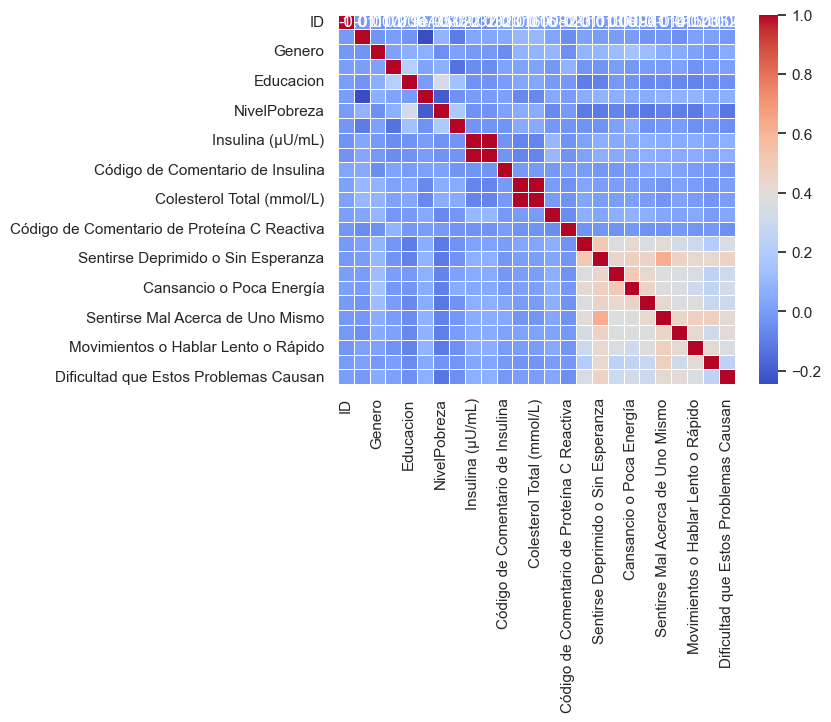

In [115]:
from sklearn.preprocessing import StandardScaler

# Estandarizar las variables
scaler = StandardScaler()
df4_scaled = pd.DataFrame(scaler.fit_transform(df4), columns=df4.columns)

# Recalcular la matriz de correlación
correlation_matrix = df4_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()



In [116]:
perfilB.head()

SEQN  LBXSATSI  LBDSATLC  LBXSAL  LBDSALSI  LBXSAPSI  LBXSASSI  \
0 109264.00      8.00      0.00    4.30     43.00    172.00     18.00   
1 109266.00     15.00      0.00    3.80     38.00     74.00     14.00   
2 109271.00      8.00      0.00    3.80     38.00     88.00     14.00   
3 109273.00     35.00      0.00    4.60     46.00     70.00     27.00   
4 109274.00     19.00      0.00    4.00     40.00     49.00     20.00   

   LBXSC3SI  LBXSBU  LBDSBUSI  ...  LBXSCA  LBDSCASI  LBXSCH  LBDSCHSI  \
0     26.00    9.00      3.21  ...    9.40      2.35  170.00      4.40   
1     25.00    8.00      2.86  ...    8.80      2.20  199.00      5.15   
2     30.00    8.00      2.86  ...    8.90      2.23  148.00      3.83   
3     27.00   11.00      3.93  ...    9.70      2.42  168.00      4.34   
4     28.00   11.00      3.93  ...    9.10      2.27  105.00      2.71   

   LBXSTP  LBDSTPSI  LBXSTR  LBDSTRSI  LBXSUA  LBDSUASI  
0    6.90     69.00   54.00      0.61    3.50    208.20  
1    6.80     68.00   86.00      0.97    4.90    291.50  
2    7.30     73.00  101.00      1.14    5.00    297.40  
3    7.40     74.00  178.00      2.01    5.20    309.30  
4    6.80     68.00  151.00      1.71    5.10    303.30  

[5 rows x 41 columns]

In [117]:
perfilB.describe()

SEQN  LBXSATSI  LBDSATLC  LBXSAL  LBDSALSI  LBXSAPSI  LBXSASSI  \
count  10409.00   9473.00   9473.00 9477.00   9477.00   9474.00   9435.00   
mean  117094.51     21.27      0.00    4.08     40.84     89.26     21.58   
std     4500.41     18.26      0.01    0.35      3.53     51.38     13.97   
min   109264.00      2.00      0.00    2.10     21.00     16.00      6.00   
25%   113190.00     12.00      0.00    3.90     39.00     63.00     16.00   
50%   117114.00     17.00      0.00    4.10     41.00     77.00     19.00   
75%   120999.00     24.00      0.00    4.30     43.00     96.00     23.00   
max   124822.00    682.00      1.00    5.40     54.00    638.00    489.00   

       LBXSC3SI  LBXSBU  LBDSBUSI  ...  LBXSCA  LBDSCASI  LBXSCH  LBDSCHSI  \
count   9473.00 9473.00   9473.00  ... 9473.00   9473.00 9475.00   9475.00   
mean      25.36   14.48      5.17  ...    9.31      2.33  180.75      4.67   
std        2.41    5.89      2.10  ...    0.38      0.09   41.07      1.06   
min       14.00    2.00      0.71  ...    6.40      1.60   72.00      1.86   
25%       24.00   11.00      3.93  ...    9.10      2.27  151.00      3.90   
50%       25.00   14.00      5.00  ...    9.30      2.33  177.00      4.58   
75%       27.00   17.00      6.07  ...    9.50      2.38  205.00      5.30   
max       38.00   79.00     28.20  ...   12.30      3.08  438.00     11.33   

       LBXSTP  LBDSTPSI  LBXSTR  LBDSTRSI  LBXSUA  LBDSUASI  
count 9473.00   9473.00 9473.00   9473.00 9473.00   9473.00  
mean     7.17     71.70  131.47      1.48    5.34    317.82  
std      0.45      4.47  101.57      1.15    1.46     86.83  
min      4.40     44.00   25.00      0.28    0.80     47.60  
25%      6.90     69.00   74.00      0.83    4.30    255.80  
50%      7.20     72.00  106.00      1.20    5.20    309.30  
75%      7.50     75.00  157.00      1.77    6.20    368.80  
max     10.00    100.00 2923.00     33.00   15.10    898.10  

[8 rows x 41 columns]

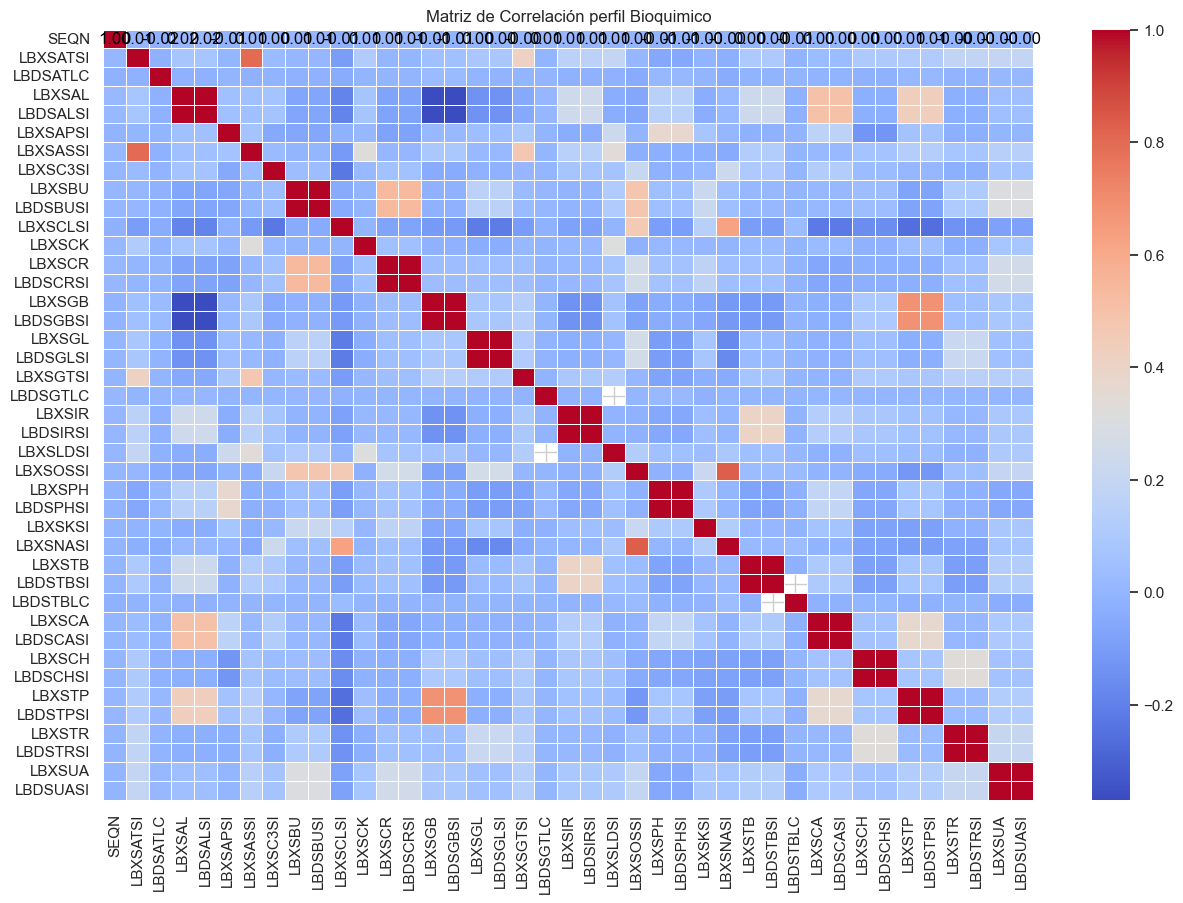

          SEQN  LBXSATSI  LBDSATLC  LBXSAL  LBDSALSI  LBXSAPSI  LBXSASSI  \
SEQN      1.00      0.01     -0.02    0.02      0.02     -0.01      0.01   
LBXSATSI  0.01      1.00     -0.02    0.08      0.08      0.00      0.80   
LBDSATLC -0.02     -0.02      1.00   -0.01     -0.01     -0.00     -0.01   
LBXSAL    0.02      0.08     -0.01    1.00      1.00      0.05      0.05   
LBDSALSI  0.02      0.08     -0.01    1.00      1.00      0.05      0.05   
LBXSAPSI -0.01      0.00     -0.00    0.05      0.05      1.00      0.07   
LBXSASSI  0.01      0.80     -0.01    0.05      0.05      0.07      1.00   
LBXSC3SI  0.00      0.03     -0.01    0.07      0.07     -0.05      0.03   
LBXSBU    0.01      0.01     -0.01   -0.07     -0.07     -0.06      0.00   
LBDSBUSI  0.01      0.01     -0.01   -0.07     -0.07     -0.06      0.00   
LBXSCLSI -0.01     -0.10     -0.04   -0.19     -0.19     -0.02     -0.11   
LBXSCK    0.01      0.12     -0.00    0.07      0.07      0.01      0.32   
LBXSCR    0.

In [118]:
df_combined_numeric = perfilB.select_dtypes(include=[np.number])
correlation_matrix = correlation_matrix.fillna(0)

# Recalcula la matriz de correlación
correlation_matrix = perfilB.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", annot_kws={"color": "black"})
plt.title('Matriz de Correlación perfil Bioquimico')
plt.show()
print(correlation_matrix)

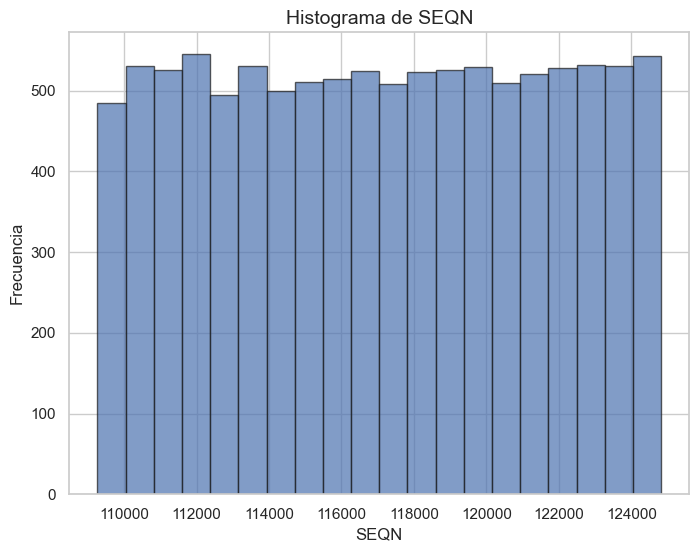

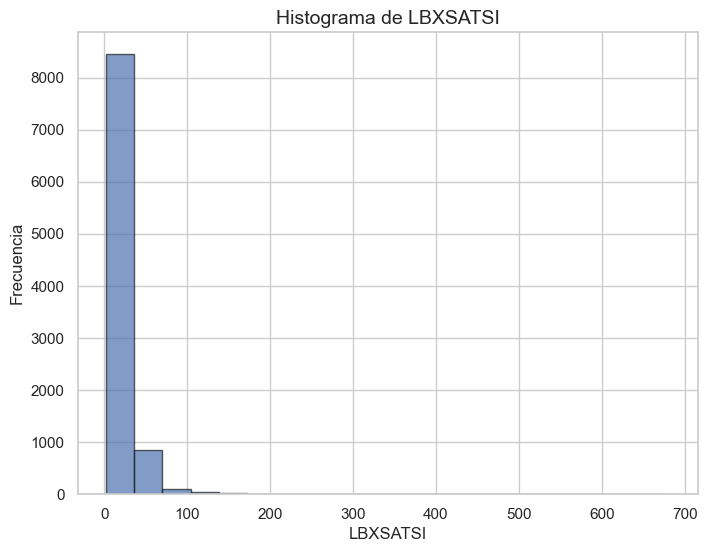

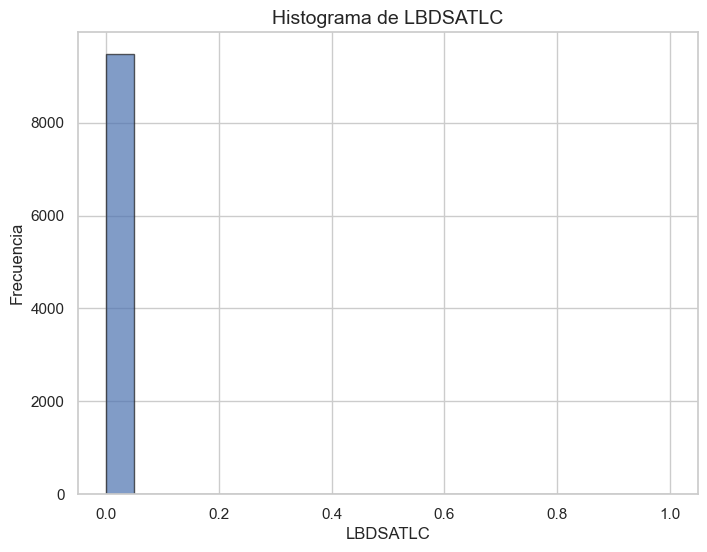

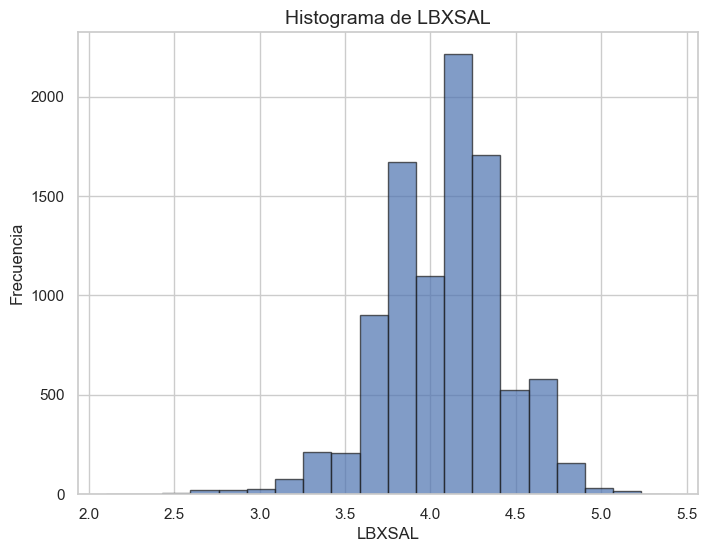

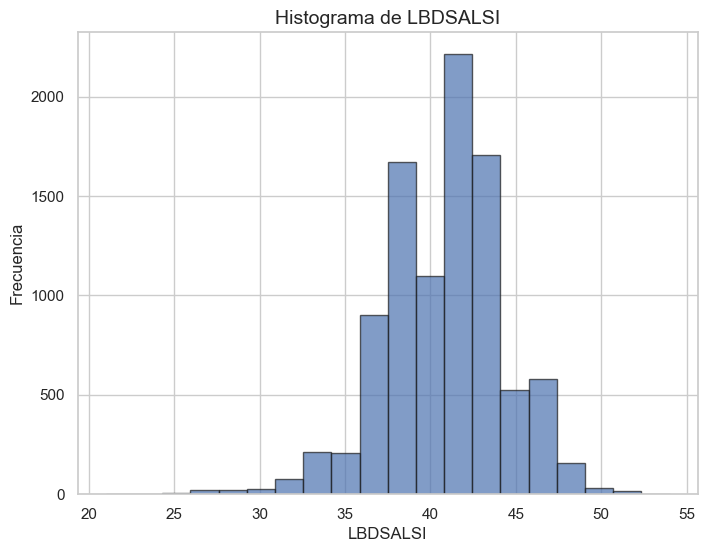

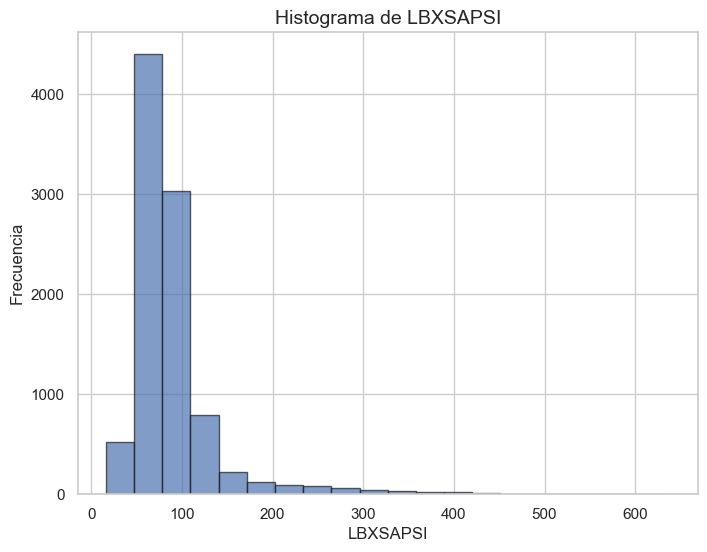

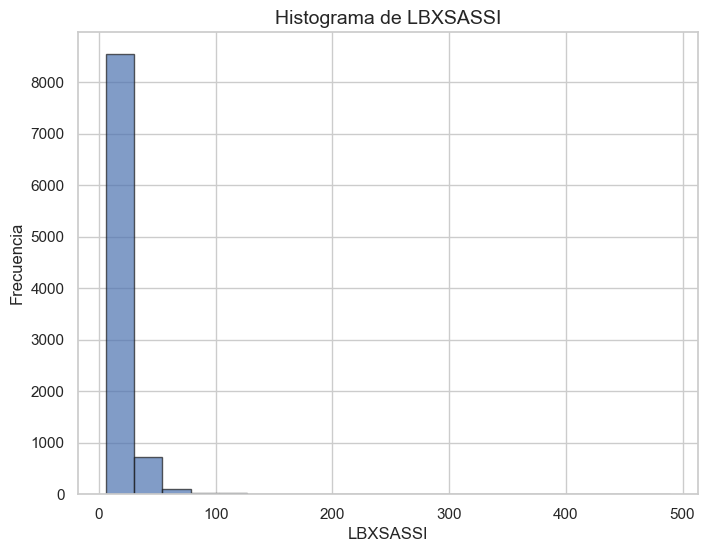

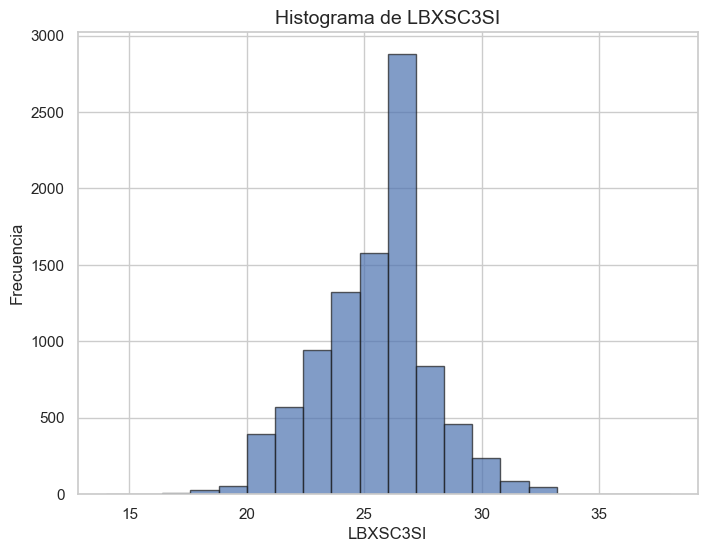

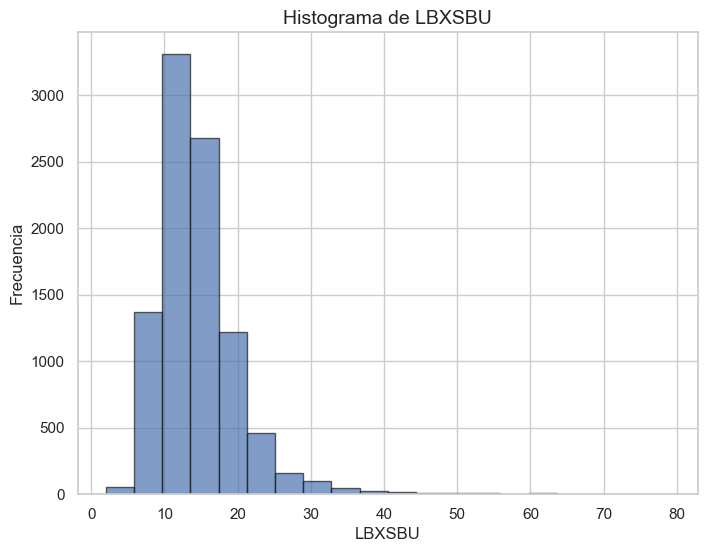

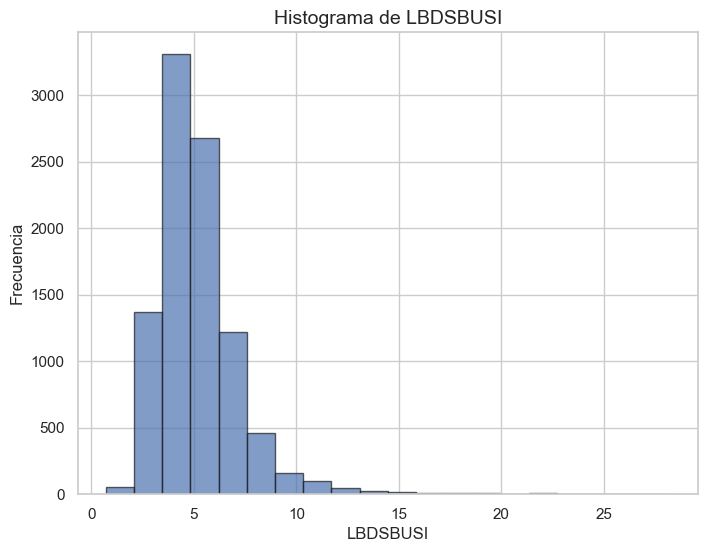

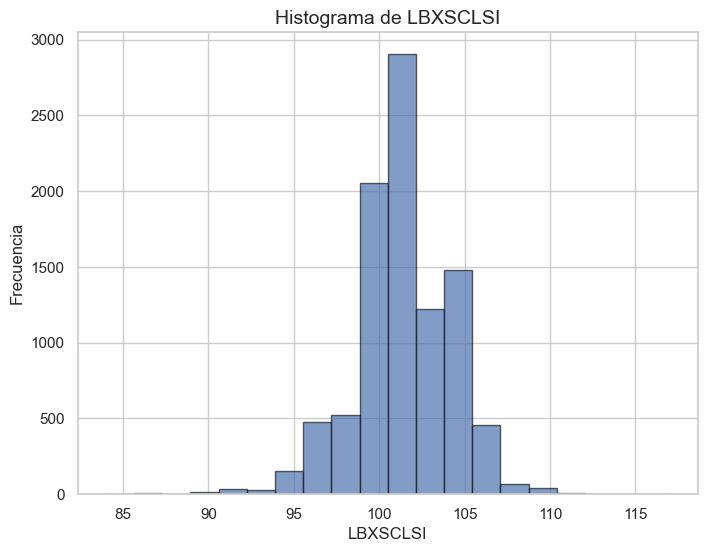

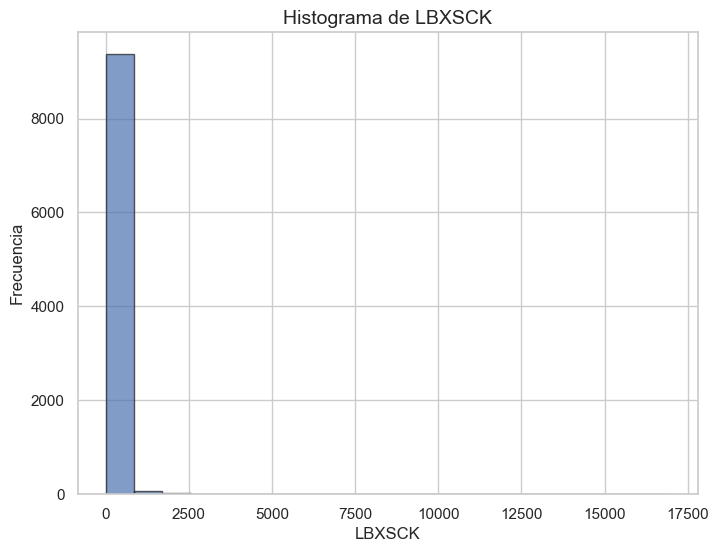

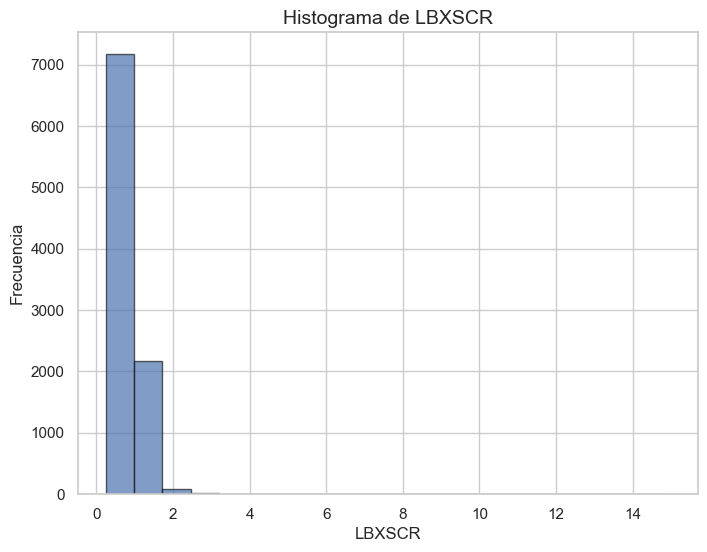

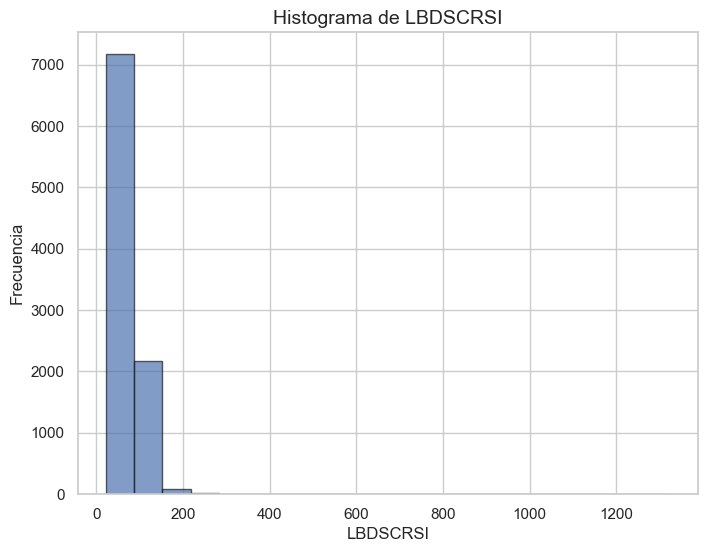

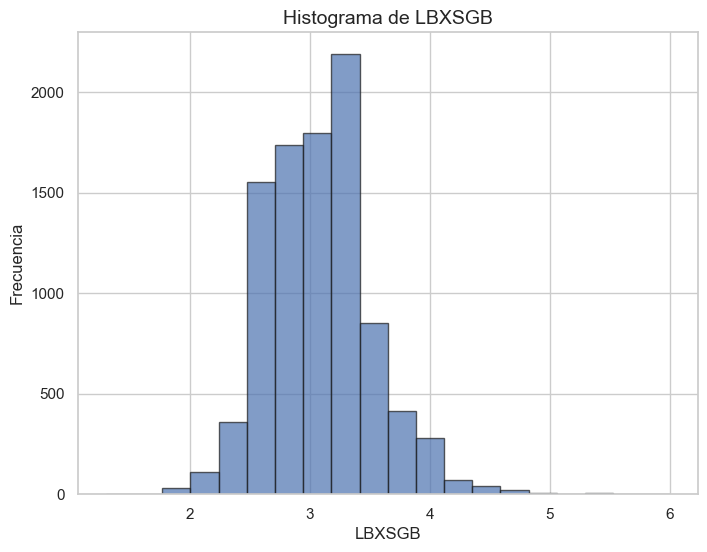

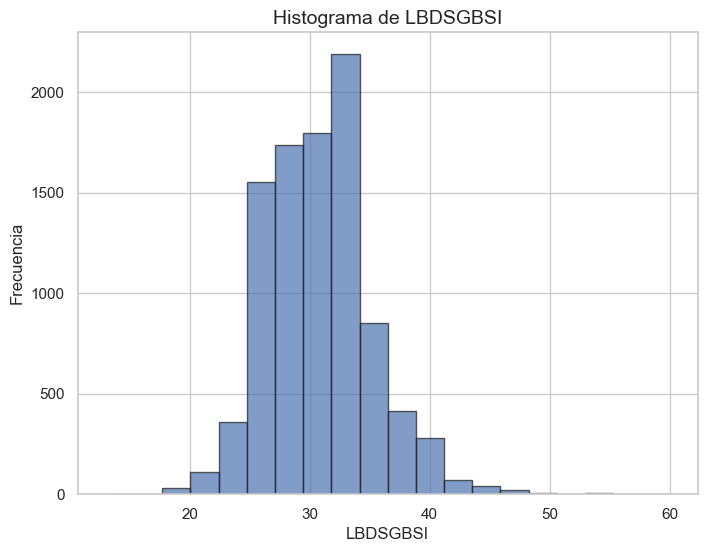

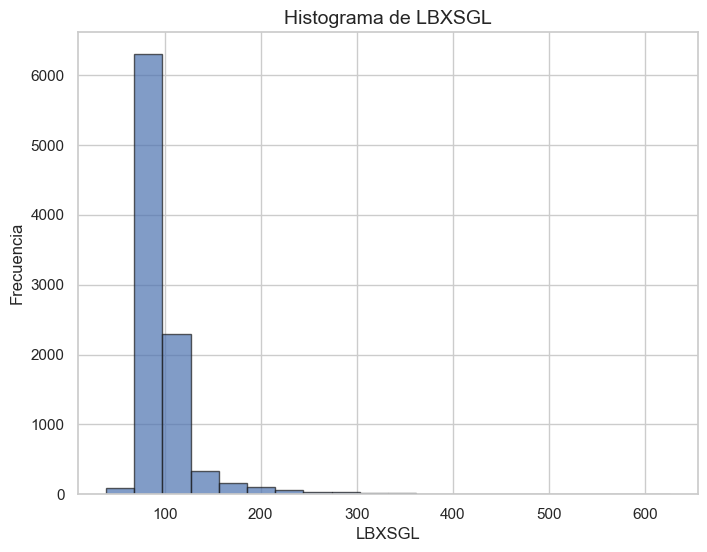

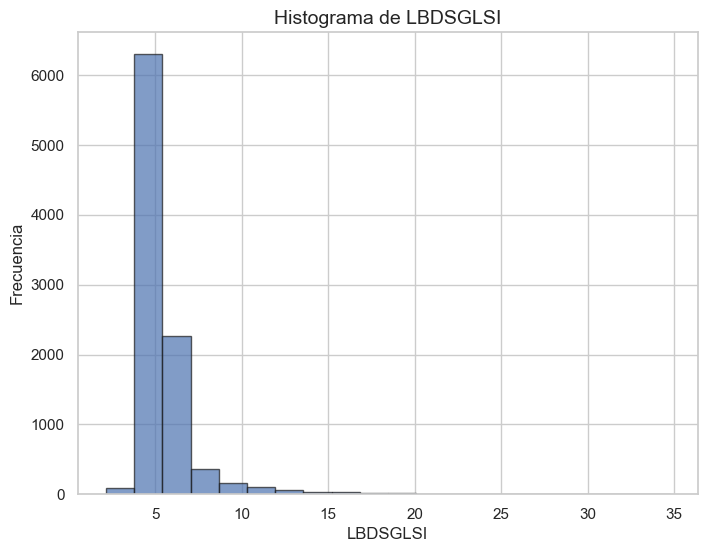

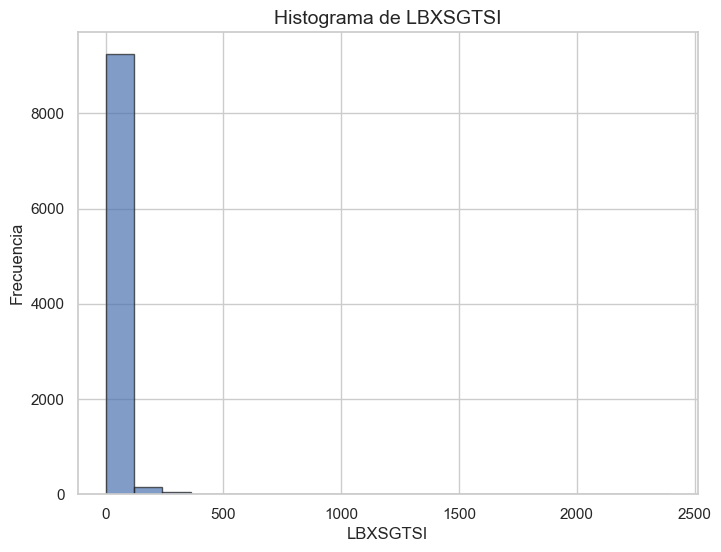

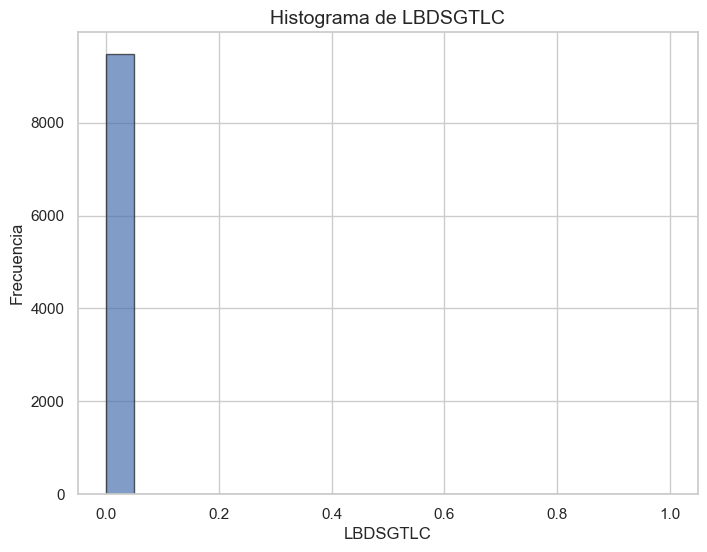

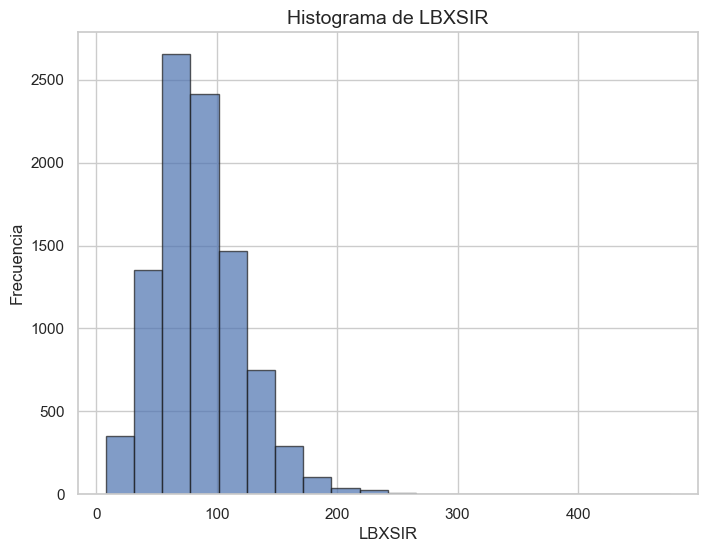

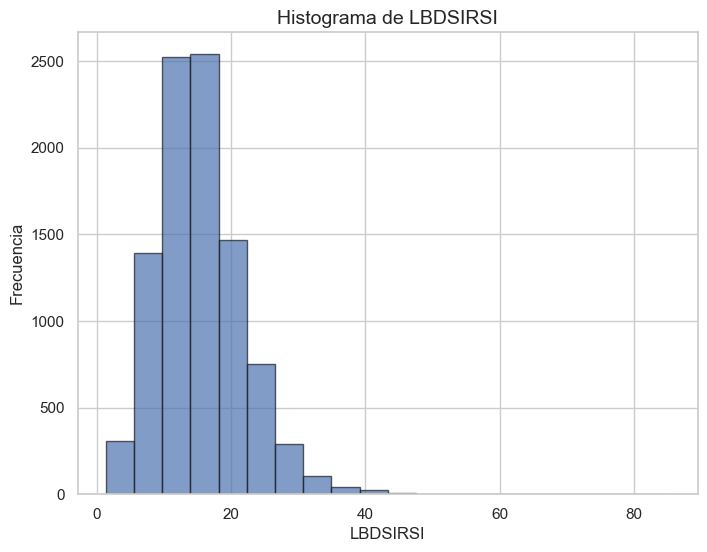

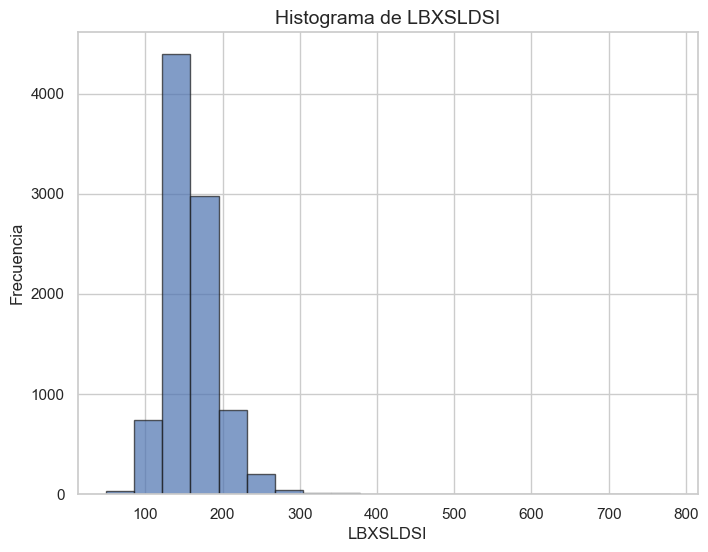

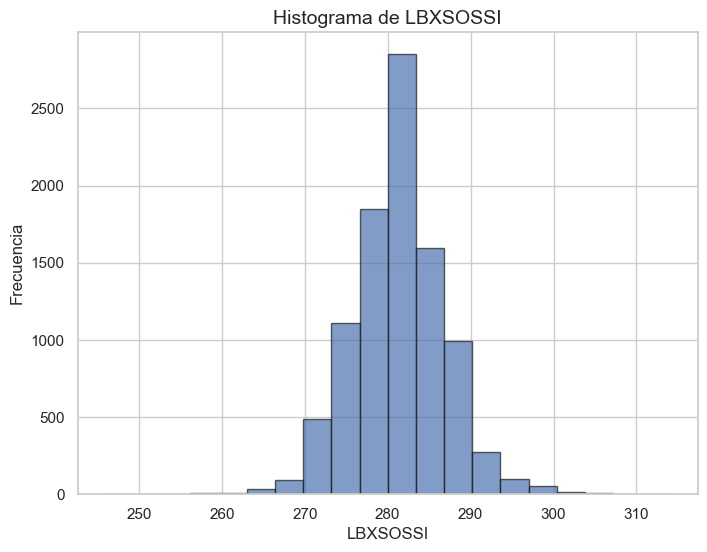

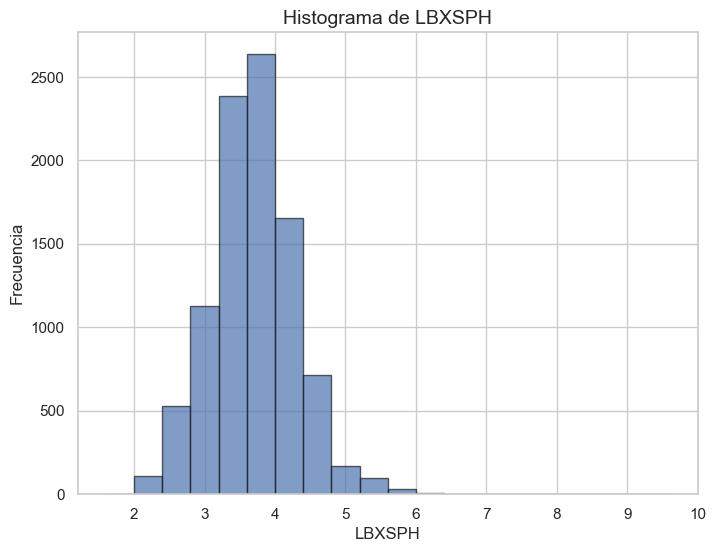

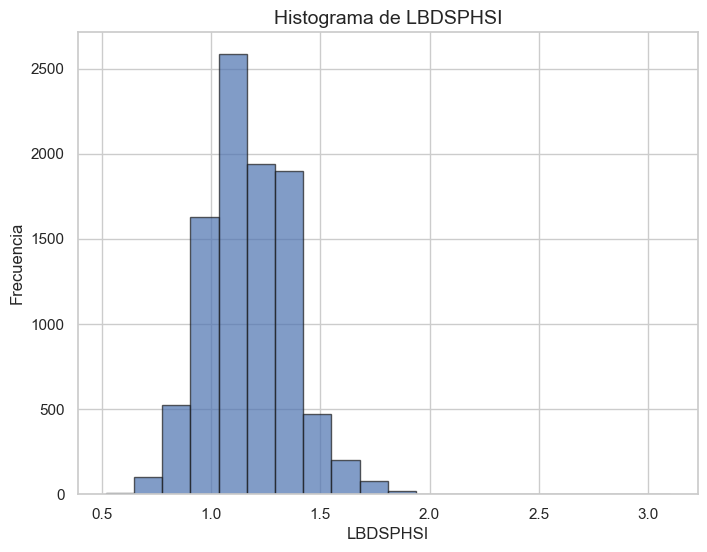

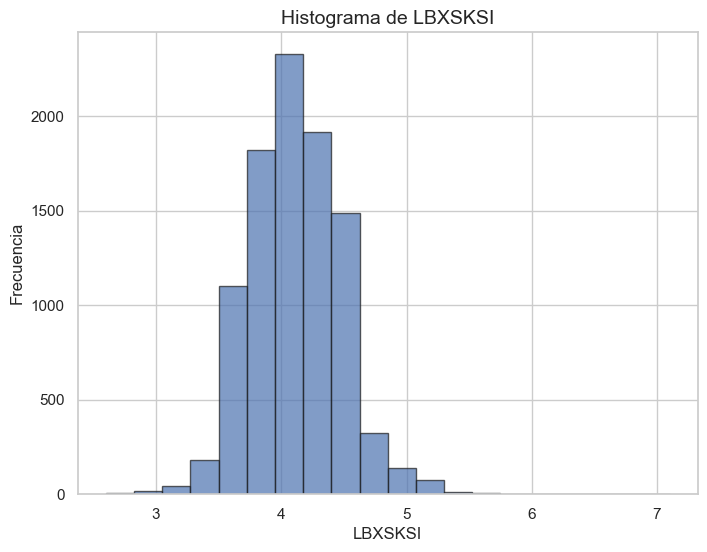

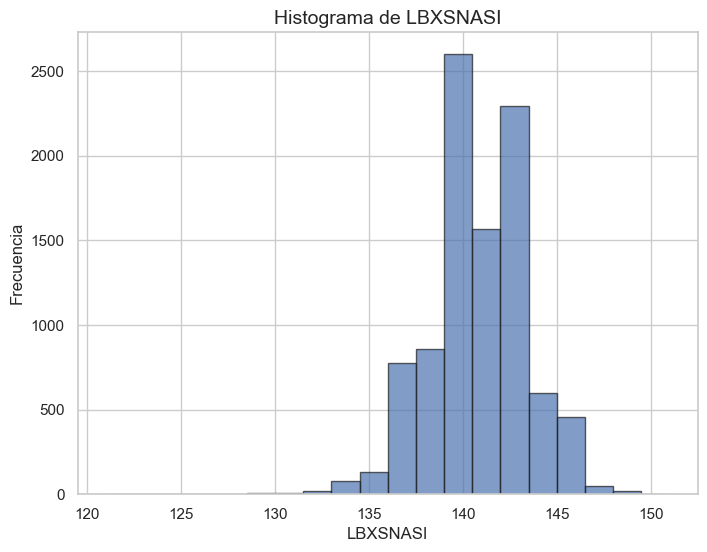

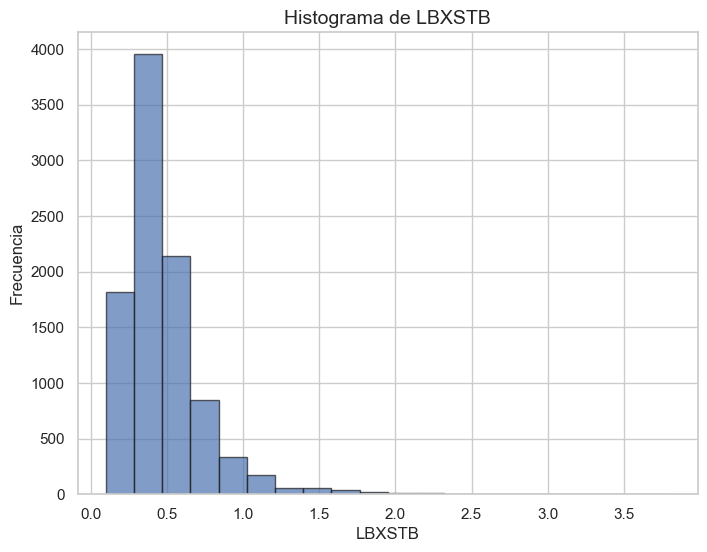

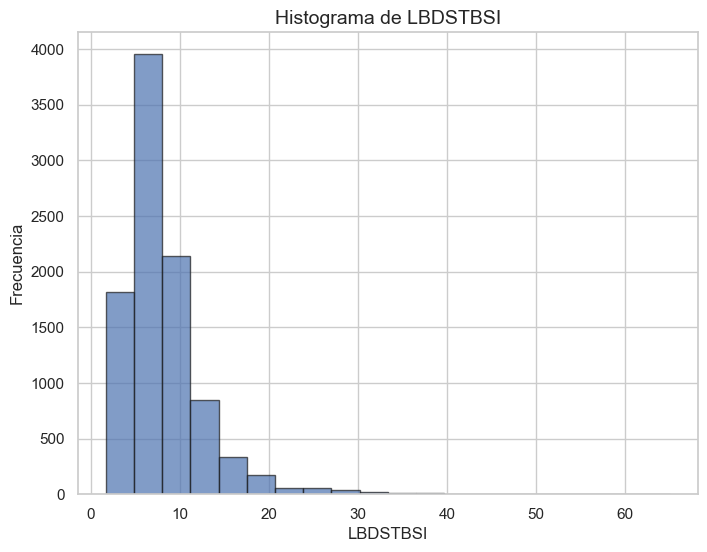

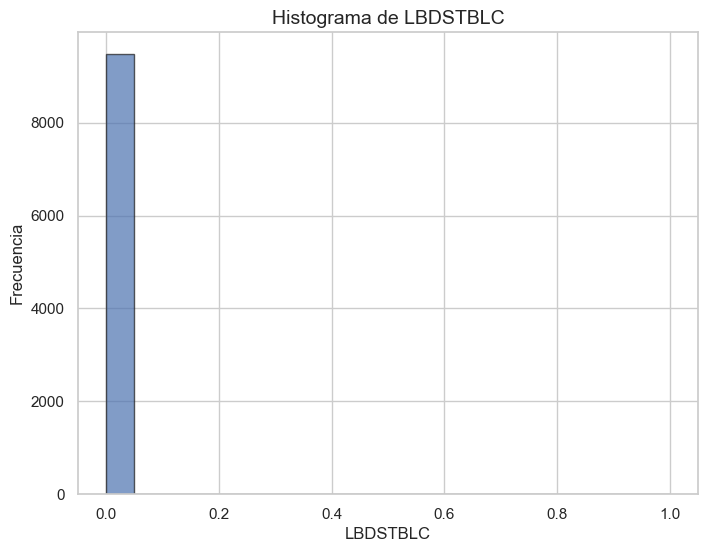

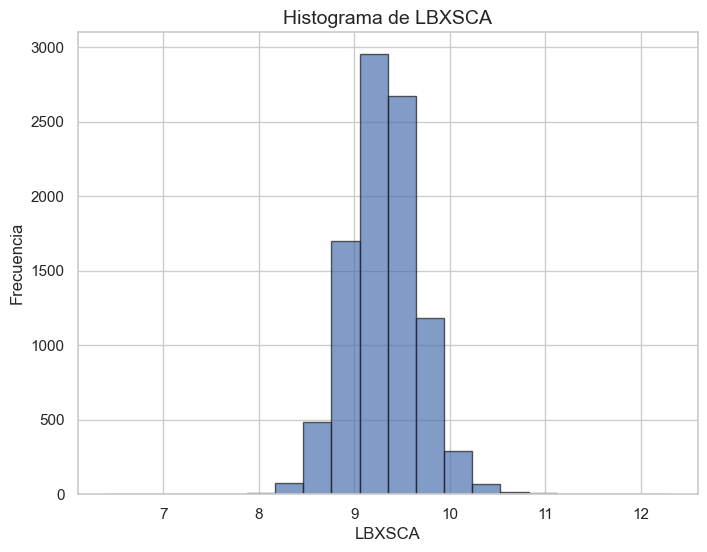

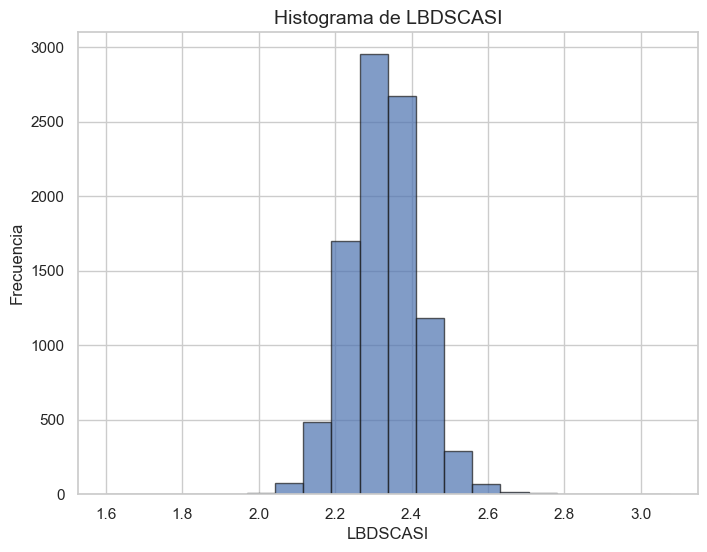

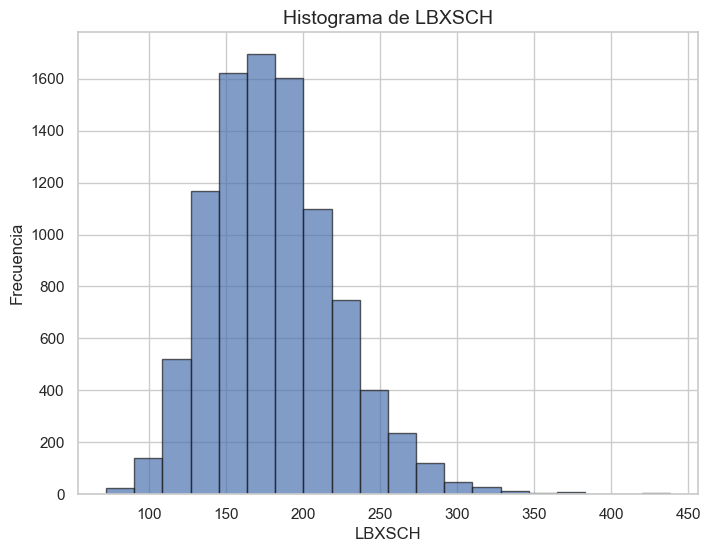

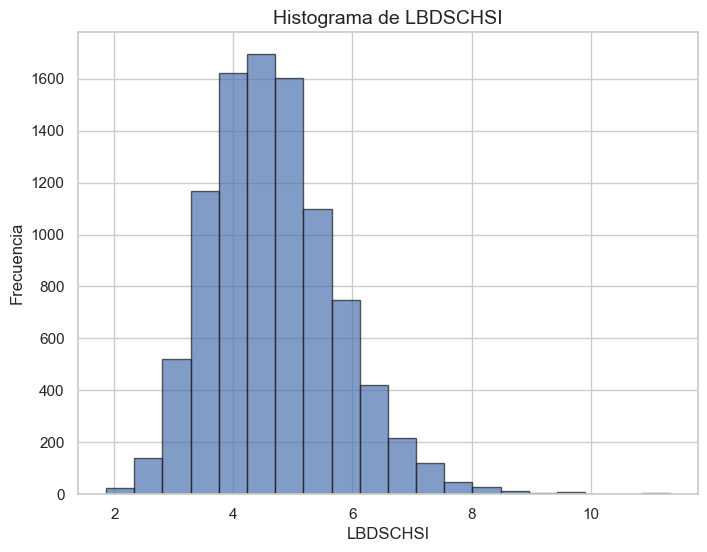

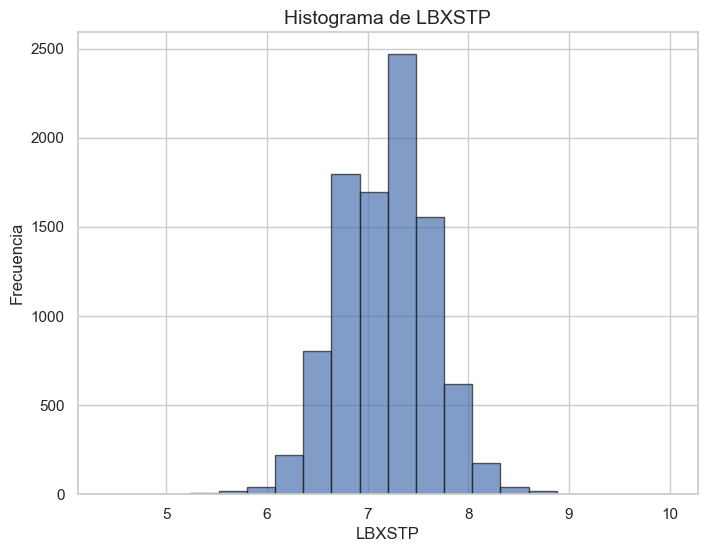

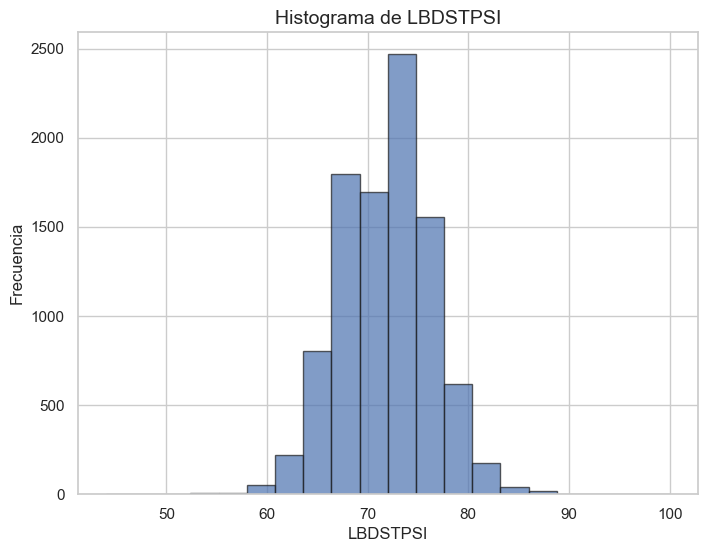

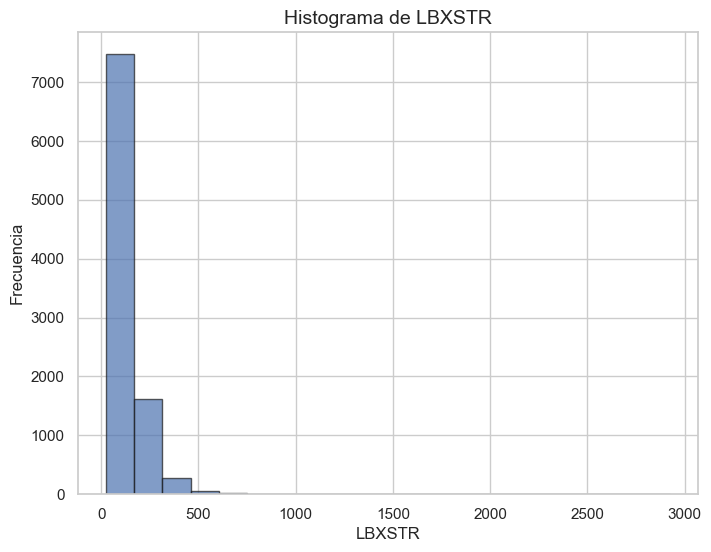

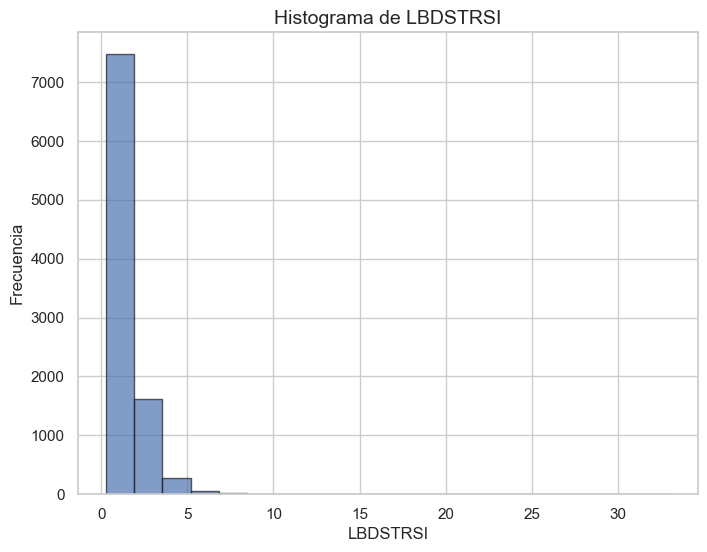

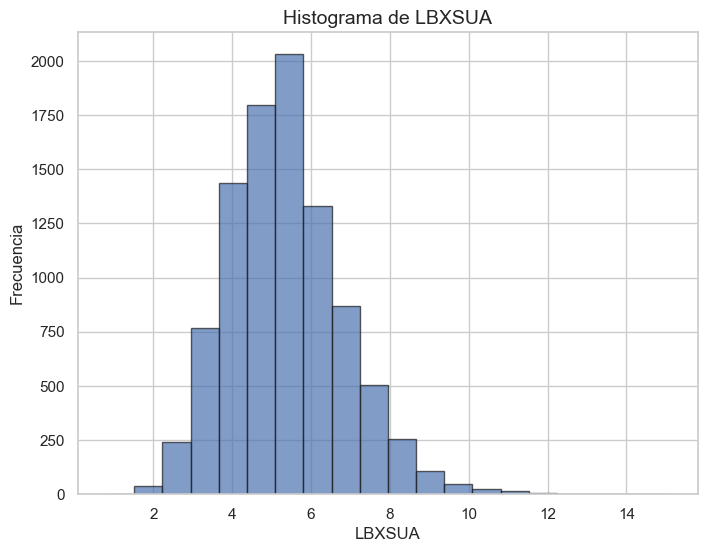

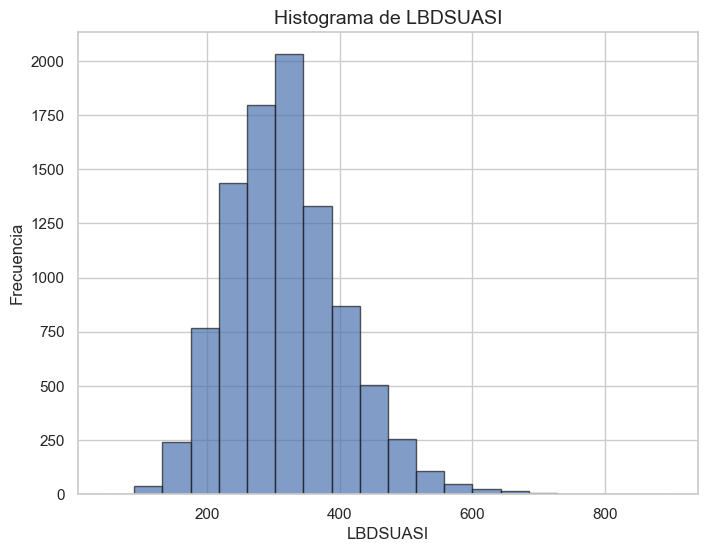

In [119]:
perfilB_numeric = perfilB.select_dtypes(include=[np.number])

for column in perfilB_numeric.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(perfilB_numeric[column].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma de {column}', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

# Pruebas: parte 2

In [58]:
demografia['Edad en años al momento del examen'].describe()


count   15560.00
mean       33.74
std        25.32
min         0.00
25%        10.00
50%        30.00
75%        56.00
max        80.00
Name: Edad en años al momento del examen, dtype: float64

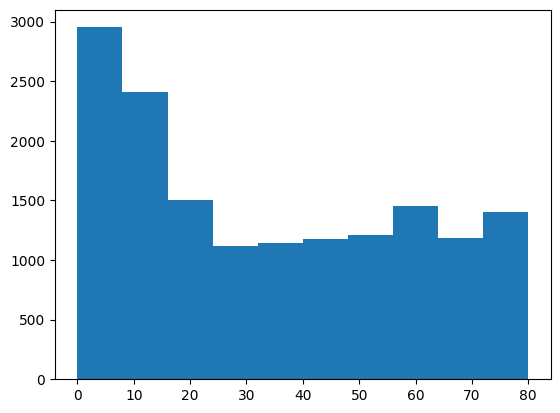

In [59]:
plt.hist(demografia['Edad en años al momento del examen'])
plt.show()

In [ ]:
edades = ['0-5', '6-10', '11,15', '16-20', '21-30','31-40','41-50', '51-60', '61-70', '70+']

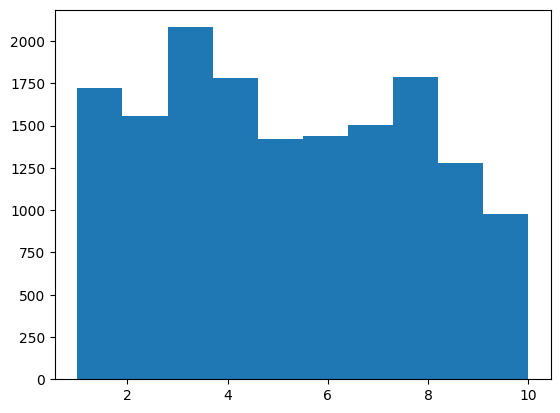

In [63]:
bins = [0,3,8,15,25,35,45,55,65,75,80,float('inf')]
labels = [1,2,3,4,5,6,7,8,9,10,11]
demografia['GrupoEdades'] = pd.cut(demografia['Edad en años al momento del examen'], bins=bins, labels=labels, right=True, include_lowest=True)
demografia['GrupoEdades'] = demografia['GrupoEdades'].astype(int)
plt.hist(demografia['GrupoEdades'])
plt.show()

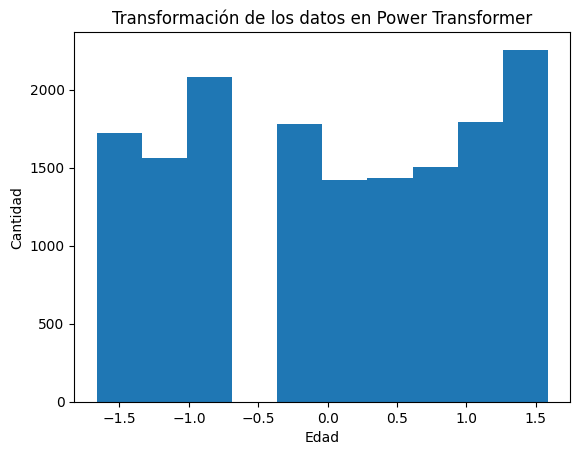

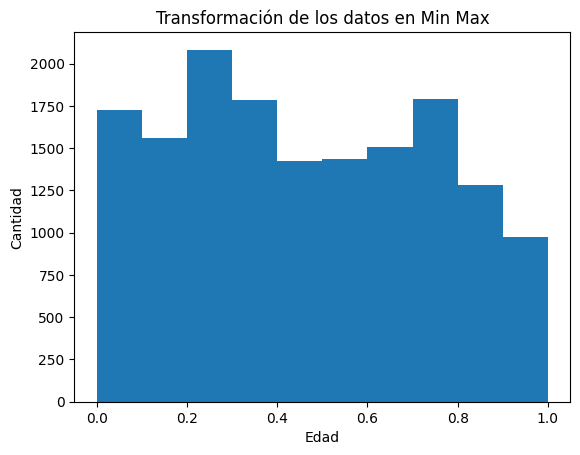

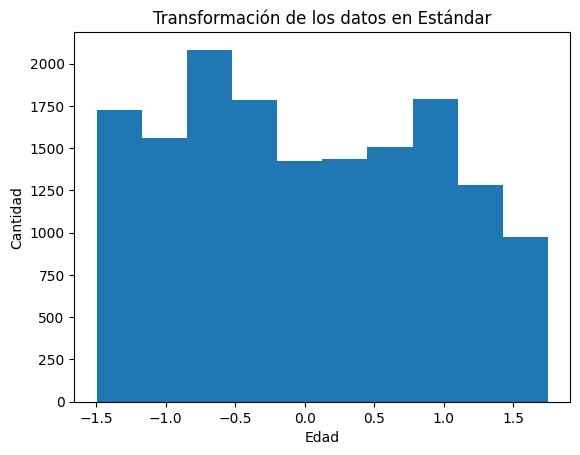

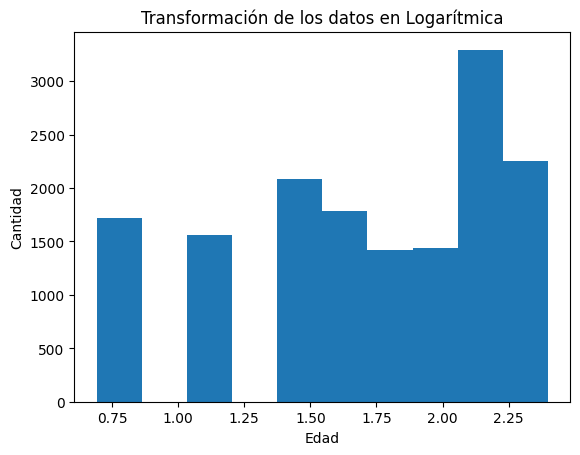

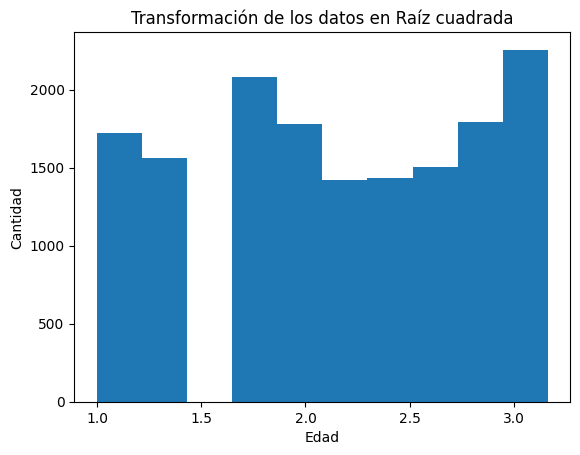

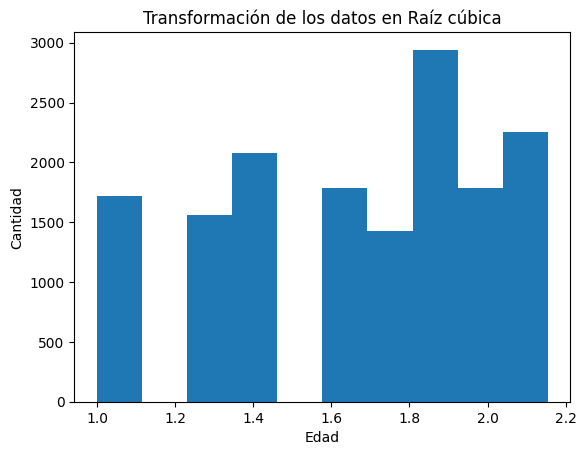

In [64]:
transformaciones = {
    'Power Transformer':pt.fit_transform(demografia[['GrupoEdades']]),
    'Min Max':minmax.fit_transform(demografia[['GrupoEdades']]),
    'Estándar':scaler.fit_transform(demografia[['GrupoEdades']]),
    'Logarítmica': np.log1p(demografia[['GrupoEdades']]),
    'Raíz cuadrada':  np.sqrt(demografia[['GrupoEdades']]),
    'Raíz cúbica': np.cbrt(demografia[['GrupoEdades']])
}

for tipo in transformaciones:
    verificar = transformaciones[tipo]
    plt.hist(verificar)
    plt.title(f"Transformación de los datos en {tipo}")
    plt.xlabel("Edad")
    plt.ylabel("Cantidad")
    plt.show()